# Исследование списка реновации от мэрии
<P>Список берем отсюда https://www.mos.ru/Renovation.pdf</P>
<P>Работаем со скаченным файлом, так удобнее</P>
<P>Общую базу домов Москвы берем отсюда https://www.reformagkh.ru - паспорта домов и их гео-координаты. Сайт госкорпорации - Фонда содействия реформированию ЖКХ. См. "Стандарт раскрытия" - официальный сайт раскрытия информации о ЖКХ</P>
<P>Базу с "Реформы ЖКХ" качаем вот этой программой https://github.com/GeorgyGol/read_tor_aigk</P>
<P>П.С. программа перестала работать, потому что админы "Реформы" поменяли параметры своего сайта, но данные были скачены заранее, этой программой. Ниже используется локальная копия. А скрипт-качалку при необходимости можно доработать</P>

In [53]:
from folium import IFrame, FeatureGroup, LayerControl
import numpy as np

import pandas as pd
import vacija as va
print(va.__version__)

import warnings
warnings.filterwarnings('ignore')

1.3


### Сервисные объявления и функции

In [54]:
square_fileds=['square', 'not_living_square', 'common_hold_square', 'living_square']
lst_work_fields=['year', 'latitude', 'longtitude', 'wall_type', 'floors', 'gutter_type', 'address',
                 'entrance', 'gas_supply_type', 'living_rooms', 'warming_type',
                 'cold_water_type', 'hot_water_type']+square_fileds

def read_and_prep(strFileName):
    dtfHouses=pd.read_csv(strFileName, encoding='cp1251', sep=';', index_col='id')
    
    dtfHouses=va.clean_for_research1(dtfHouses)[lst_work_fields]
    dtfHouses=dtfHouses[dtfHouses['latitude'].notnull()]
    #дубликаты по координатам!!!
    dtfHouses[['latitude', 'longtitude']]=dtfHouses[['latitude', 'longtitude']].round(5)
    dtfHouses[square_fileds]=dtfHouses[square_fileds].apply(lambda x: pd.to_numeric(x, errors='coerce').fillna(0))
    return dtfHouses.drop_duplicates(['latitude', 'longtitude'])


dct_walls_colors={'Каменные, кирпичные': 'maroon', 
 'Иные': 'lightblue', 
 'Деревянные': 'burlywood', 
 'Смешанные': 'peru', 
 'Блочные': 'lightgray', 
 'Панельные': 'lightgreen', 
 'Монолитные':'plum'}

reno_pdf=r'/home/egor/git/jupyter/vacija/Houses/Renovation.pdf'

In [55]:
lst_years=list(range(1870, 2030, 20))
ci_start_year=1890
y_pairs=[(lst_years[i], lst_years[i+1]) for i in range(len(lst_years)-1)]
y_pairs[0]=(0, ci_start_year)

mrk_colors=['black', 'gray', 'lightgray', 'darkred', 'red', 'lightred', 'darkgreen', 'green', 'lightgreen', 'darkblue',
           'blue', 'lightblue', 'darkpurple', 'purple', 'pink', 'beige']

#print(list(zip(y_pairs,mrk_colors)))

def make_popup(df, year=True):
    tbl_h='''<font size='xx-small'><table width='100%' border='0'>'''
    tbl_mess='''<tr>
                <td width='40%' style='font-size:small'><b>{0}:</b></td>
                <td width='60%' style='font-size:small'>{1}</td>
                </tr>'''
    tbl_end='''</table></font>'''
    tbl_mm='''
                <tr>
                <td colspan=2 style='font-size:small'><b>{0}</b></td>
                </tr>'''
    tbl_coord='''
                <tr>
                <td colspan=2 style='font-size:small'>LatLon= ({0} {1})</td>
                </tr>'''
    tbl_body=''
    tbl_body+= tbl_mm.format(df['address'])
    tbl_body+= tbl_coord.format(df['latitude'], df['longtitude'])
    
    try:
        tbl_body+= tbl_mess.format('Год постройки', round(df['year']))
    except ValueError:
        tbl_body+= tbl_mm.format('Год постройки отсутствует')
        
    tbl_body+= tbl_mess.format('Материал стен', df['wall_type'])
    
    try:
        tbl_body+= tbl_mess.format('Этажность', round(df['floors']))
    except ValueError:
        tbl_body+= tbl_mess.format('Этажность', 'Не указано')
    try:
        tbl_body+= tbl_mess.format('Подъездов', round(df['entrance']))
    except ValueError:
        tbl_body+= tbl_mess.format('Подъездов', 'Не указано')
        
    tbl_body+= tbl_mess.format('Газоснабжение', df['gas_supply_type'])
    tbl_body+= tbl_mess.format('Отопление', df['warming_type'])
    tbl_body+= tbl_mess.format('Вода хол.', df['cold_water_type'])
    tbl_body+= tbl_mess.format('Вода гор.', df['hot_water_type'])
    tbl_body+= tbl_mess.format('Жилая площадь', df['living_square'])
    tbl_body+= tbl_mess.format('Общая площадь', df['square'])
    return tbl_h+tbl_body+tbl_end

def draw_marker(dtfrm, add_to=None, num_sides=3, fl_color='black', sd_color='grey', rad=7, is_year=True):
    for ir in dtfrm.iterrows():
        #print('\t{0} - {1} (lat:{2} - long:{3})'.format(ir[0], ir[1]['address'], 
        #                                                ir[1]['latitude'], ir[1]['longtitude']))
        coord=[ir[1]['latitude'], ir[1]['longtitude']]
        iframe=folium.IFrame(make_popup(ir[1], year=is_year), 270, 170)
        folium.RegularPolygonMarker(coord, popup=folium.Popup(iframe, max_width=2650), 
                                    fill_color=fl_color, color=sd_color, weight=1,
                                    number_of_sides=num_sides, 
                                    radius=rad).add_to(add_to)
        
def map_marker(dtf, color='red', icon='home', add_to=None):
    if add_to is None:
        add_to=folium.Map(location=[55.4521, 37.3704], zoom_start=3)
    for r in dtf.iterrows():
        coord=[r[1]['latitude'], r[1]['longtitude']]
        iframe=folium.IFrame(make_popup(r[1], r[1]['year']!=np.nan), 270, 170)
        folium.Marker(coord, popup=folium.Popup(iframe, max_width=2650), 
                        icon=folium.Icon(color=color, icon=icon)).add_to(add_to)
    #map_osm.add_child(folium.LatLngPopup())
    return add_to

def map_marker_text(dtf, color='red', icon='home', add_to=None):
    if add_to is None:
        add_to=folium.Map(location=[55.4521, 37.3704], zoom_start=3)
    for r in dtf.iterrows():
        coord=[r[1]['latitude'], r[1]['longtitude']]
        strMess='{0}, год {1:.0f}, cтены "{3}", этажей {2:.0f}'.format(r[1]['address'], 
                                                                       r[1]['year'], 
                                                                       r[1]['floors'],
                                                                      r[1]['wall_type'])
        folium.RegularPolygonMarker(coord, popup=strMess, fill_color=color, color=color, weight=1,
                                    number_of_sides=5, radius=3).add_to(add_to)
    #map_osm.add_child(folium.LatLngPopup())
    return add_to

## Читаем исходные данные
### Сначала с локальной копии "Реформы ЖКХ"

In [56]:
dtfHouses=read_and_prep(r'/home/egor/git/jupyter/vacija/Houses/moscow_houses.csv')
print(dtfHouses.shape)

(32839, 17)


### А потом парсим PDF-файл со списком от мэрии
<p>Кстати очень интересный нюанс: мэрия делает все возможное, чтобы затруднить работу со списком. Сначала его просто не было - была карта со сносимыми домами. Красиво, но это не данные</p>
<p>А теперь это список в pdf-формате. Не самый удобный формат для данных</p>

In [61]:
from pdfminer.pdfparser import PDFParser, PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import PDFPageAggregator
from pdfminer.layout import LAParams, LTTextBox, LTTextLine

reno_list=set()

fp = open(reno_pdf, 'rb')
parser = PDFParser(fp)
doc = PDFDocument()
parser.set_document(doc)
doc.set_parser(parser)
doc.initialize('')
rsrcmgr = PDFResourceManager()
laparams = LAParams()
device = PDFPageAggregator(rsrcmgr, laparams=laparams)
interpreter = PDFPageInterpreter(rsrcmgr, device)
# Process each page contained in the document.
for page in doc.get_pages():
    interpreter.process_page(page)
    layout = device.get_result()
    for lt_obj in layout:
        if isinstance(lt_obj, LTTextBox) or isinstance(lt_obj, LTTextLine):
            #strings={s for s in lt_obj.get_text().split('\n')}
            reno_list.update({s for s in lt_obj.get_text().split('\n')})
            

reno_list={x for x in reno_list if len(x.split(' '))>3}
reno_list.remove('Дома, включенные в программу реновации')

for i, s in enumerate(sorted(reno_list)):
    print (i, s)
print(len(reno_list))

fp.close()
#print(plain_text)
print('all done')

0 1-й Ботанический проезд, дом 1
1 1-й Ботанический проезд, дом 3
2 1-й Ботанический проезд, дом 3А
3 1-й Волоколамский проезд, дом 7, корпус 1
4 1-й Волоколамский проезд, дом 7, корпус 2
5 1-й Грайвороновский проезд, дом 6
6 1-й Коптельский переулок, дом 9, строение 2
7 1-й Красногвардейский проезд, дом 18/1, корпус 3
8 1-й Красногвардейский проезд, дом 20
9 1-й Красногвардейский проезд, дом 20А
10 1-й Лихачёвский переулок, дом 4, корпус 2А
11 1-й Лихачёвский переулок, дом 4, корпус 3
12 1-й Лихачёвский переулок, дом 4А
13 1-й Лихачёвский переулок, дом 6
14 1-й Люберецкий проезд, дом 9
15 1-й Люберецкий проезд, дом 9А
16 1-й Люберецкий проезд, дом 9Б, строение 3
17 1-й Новомихалковский проезд, дом 10
18 1-й Новомихалковский проезд, дом 12
19 1-й Новомихалковский проезд, дом 14
20 1-й Новомихалковский проезд, дом 4
21 1-й Новомихалковский проезд, дом 6
22 1-й Новомихалковский проезд, дом 8
23 1-й Очаковский переулок, дом 4
24 1-й Павелецкий проезд, дом 1/42, корпус 1
25 1-й Павелецкий 

582 Анадырский проезд, дом 9
583 Ангарская улица, дом 2, корпус 1
584 Ангарская улица, дом 2, корпус 2
585 Ангарская улица, дом 21
586 Ангарская улица, дом 23, корпус 3
587 Ангарская улица, дом 23, корпус 4
588 Ангарская улица, дом 25
589 Ангарская улица, дом 27
590 Ангарская улица, дом 27А
591 Ангарская улица, дом 29
592 Ангарская улица, дом 31
593 Ангарская улица, дом 33
594 Ангарская улица, дом 43
595 Ангарская улица, дом 5
596 Ангарская улица, дом 7, корпус 1
597 Ангарская улица, дом 7, корпус 2
598 Анненская улица, дом 1
599 Анненская улица, дом 2
600 Анненская улица, дом 4
601 Анненская улица, дом 5
602 Анненская улица, дом 7, корпус 1
603 Анненская улица, дом 7, корпус 2
604 Анненская улица, дом 9
605 Аптекарский переулок, дом 8
606 Армавирская улица, дом 23/18
607 Армавирская улица, дом 25
608 Армавирская улица, дом 27/23
609 Армавирская улица, дом 6
610 Артековская улица, дом 7, корпус 1
611 Артековская улица, дом 7, корпус 2
612 Артековская улица, дом 7, корпус 3
613 Артековс

1710 Краснодонская улица, дом 23, корпус 2
1711 Краснодонская улица, дом 25
1712 Краснодонская улица, дом 3, корпус 1
1713 Краснодонская улица, дом 3, корпус 2
1714 Краснодонская улица, дом 3, корпус 3
1715 Краснодонская улица, дом 4
1716 Краснодонская улица, дом 49/17
1717 Краснодонская улица, дом 5, строение 1
1718 Краснодонская улица, дом 5, строение 2
1719 Красноказарменная улица, дом 12, корпус 4
1720 Красноказарменная улица, дом 2, корпус 1
1721 Краснолиманская улица, дом 21
1722 Краснолиманская улица, дом 23
1723 Краснолиманская улица, дом 25
1724 Краснолиманская улица, дом 27
1725 Красносолнечная улица, дом 40, корпус 1
1726 Красносолнечная улица, дом 40, корпус 2
1727 Красносолнечная улица, дом 40, корпус 3
1728 Кременчугская улица, дом 34, корпус 1
1729 Кременчугская улица, дом 34, корпус 2
1730 Кременчугская улица, дом 36
1731 Кременчугская улица, дом 38, корпус 1
1732 Кременчугская улица, дом 38, корпус 2
1733 Кременчугская улица, дом 40, корпус 1
1734 Кременчугская улица, 

2413 Открытое шоссе, дом 27, корпус 5
2414 Открытое шоссе, дом 27, корпус 6
2415 Открытое шоссе, дом 27, корпус 7
2416 Открытое шоссе, дом 28, корпус 10
2417 Открытое шоссе, дом 28, корпус 11
2418 Открытое шоссе, дом 28, корпус 7
2419 Открытое шоссе, дом 28, корпус 8
2420 Открытое шоссе, дом 28, корпус 9
2421 Открытое шоссе, дом 29, корпус 10
2422 Открытое шоссе, дом 29, корпус 11
2423 Открытое шоссе, дом 29, корпус 2
2424 Открытое шоссе, дом 29, корпус 9
2425 Открытое шоссе, дом 3, корпус 1
2426 Открытое шоссе, дом 3, корпус 10
2427 Открытое шоссе, дом 3, корпус 11
2428 Открытое шоссе, дом 3, корпус 12
2429 Открытое шоссе, дом 3, корпус 13
2430 Открытое шоссе, дом 3, корпус 4
2431 Открытое шоссе, дом 3, корпус 5
2432 Открытое шоссе, дом 3, корпус 6
2433 Открытое шоссе, дом 3, корпус 7
2434 Открытое шоссе, дом 3, корпус 9
2435 Открытое шоссе, дом 5, корпус 1
2436 Открытое шоссе, дом 5, корпус 10
2437 Открытое шоссе, дом 5, корпус 11
2438 Открытое шоссе, дом 5, корпус 12
2439 Открытое ш

3433 Яснополянская улица, дом 3, корпус 1
3434 Яснополянская улица, дом 5
3435 бульвар Генерала Карбышева, дом 10, корпус 2
3436 бульвар Генерала Карбышева, дом 10, корпус 3
3437 бульвар Генерала Карбышева, дом 12
3438 бульвар Генерала Карбышева, дом 14, корпус 2
3439 бульвар Генерала Карбышева, дом 14, корпус 3
3440 бульвар Генерала Карбышева, дом 14, корпус 4
3441 бульвар Генерала Карбышева, дом 16, корпус 2
3442 бульвар Генерала Карбышева, дом 18, корпус 2
3443 бульвар Генерала Карбышева, дом 18, корпус 3
3444 бульвар Генерала Карбышева, дом 18, корпус 4
3445 бульвар Генерала Карбышева, дом 19, корпус 3
3446 бульвар Генерала Карбышева, дом 2
3447 бульвар Генерала Карбышева, дом 20
3448 бульвар Генерала Карбышева, дом 24, корпус 1
3449 бульвар Генерала Карбышева, дом 5, корпус 2
3450 бульвар Генерала Карбышева, дом 6, корпус 1
3451 бульвар Генерала Карбышева, дом 6, корпус 2
3452 бульвар Генерала Карбышева, дом 6, корпус 3
3453 бульвар Генерала Карбышева, дом 6, корпус 4
3454 бульвар

4580 улица Маршала Новикова, дом 21
4581 улица Маршала Новикова, дом 6, корпус 1
4582 улица Маршала Новикова, дом 6, корпус 2
4583 улица Маршала Новикова, дом 8, корпус 1
4584 улица Маршала Новикова, дом 8, корпус 2
4585 улица Маршала Новикова, дом 8, корпус 3
4586 улица Маршала Рыбалко, дом 4-В
4587 улица Маршала Тухачевского, дом 22, корпус 2
4588 улица Маршала Тухачевского, дом 24, корпус 2
4589 улица Маршала Тухачевского, дом 38, корпус 2
4590 улица Маршала Тухачевского, дом 40, корпус 1
4591 улица Маршала Тухачевского, дом 40, корпус 2
4592 улица Маршала Тухачевского, дом 42, корпус 1
4593 улица Маршала Тухачевского, дом 42, корпус 2
4594 улица Маршала Тухачевского, дом 44, корпус 2
4595 улица Маршала Тухачевского, дом 58
4596 улица Маршала Чуйкова, дом 13, корпус 1
4597 улица Маршала Чуйкова, дом 13, корпус 2
4598 улица Маршала Чуйкова, дом 13, корпус 3
4599 улица Маршала Чуйкова, дом 18/50
4600 улица Маршала Чуйкова, дом 22, корпус 1
4601 улица Маршала Чуйкова, дом 22, корпус 2


## Сопоставляем записи из списка мэрии и из базы "Реформы ЖКХ"
<p>Формат адресов в базах разный, база "Реформы" заполняется управляющими компаниями, там о едином формате адреса вообще говорить сложно, и в самих адресах случаются ошибки</p>
<p>Формат адресов в базах разный, база "Реформы" заполняется управляющими компаниями, там о едином формате адреса вообще говорить сложно, и в самих адресах случаются ошибки</p>
<p>Для сопоставления используем https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%96%D0%B0%D0%BA%D0%BA%D0%B0%D1%80%D0%B0 реализацию из библиотеки ntlk</p>
<p>Коэффициент работает довольно точно, но ошибки все же присутствуют</p>
<p><b>При сопоставлении баз возможны ошибки в адресах!!! Ошшибки возникают из-за либо из-за отстутсвия соответствия мэрской базы в базе "Реформы", либо из-за сильной разницы в формате адреса</b></p>
<p>С ошибками боремся...</p>

In [77]:
import re
import nltk
from nltk.metrics.distance import edit_distance
from nltk.metrics.distance import jaccard_distance

dct_replace={'б-р\.':'бульвар', 'ш\.':'шоссе', 'ул\.':'улица', 'наб\.':'набережная', 'кв-л\.':'квартал',
             'п\.':'поселок ', 'г\.':'город', 'к\. ':'корпус_', ', д\. ':', дом_', '№':'', ', дом_-':'',
             'дом_проезд':'проектируемый проезд', 'мкр\.':'микрорайон',
             'пр-кт\.':'проспект', 'пер\.':'переулок'}
dct_replace_mer= {'северное измайлово ':'', 'покровское-стрешнево ':'', 'дом ':'дом_', 'корпус ':'корпус_',
             'москворечье-сабурово ':'', '"мосрентген"':'мосрентген', 'очаково-матвеевское ':'', 'ё':'е'}

#def dom_korp(x):
    

dtfReno=pd.DataFrame({'address': list(reno_list)})
dtfReno['norm_addr']=dtfReno['address'].str.lower()

for ky, v in dct_replace_mer.items():
    dtfReno['norm_addr']=dtfReno['norm_addr'].str.replace(ky, v)
#print(dtfReno['norm_addr'])


k=dtfHouses[dtfHouses['floors']<10].reset_index()

dtfResult=k.drop(k.index)
dtfResult['base_addr']=''

k['norm_addr']=k['address'].str.lower()
for ky, v in dct_replace.items():
    k['norm_addr']=k['norm_addr'].str.replace(ky, v)

#print(k['norm_addr'].tolist())
#print(k.ix[k['norm_addr'].str.contains(r'дом_\D'), 'norm_addr'].tolist())

for i in range(dtfReno.shape[0]):
    k['dist']=k['norm_addr'].apply(lambda x: jaccard_distance(set(re.split(r'\W+', x)), 
                                                            set(re.split(r'\W+', dtfReno.ix[i, 'norm_addr']))))
    print('for step {0} from {1}: found a match {2} - {3}'.format(i, dtfReno.shape[0], 
                                                                  k.ix[k['dist'].idxmin, 'address'], 
                                                                  dtfReno.ix[i, 'address']))
    dtfResult=dtfResult.append(k.ix[k['dist'].idxmin])
    dtfResult.ix[dtfResult.tail(1).index, 'base_addr']=dtfReno.ix[i, 'address']
    
print('all done')


for step 0 from 5143: found a match ул. Ереванская, д. 24, к. 2 - Ереванская улица, дом 24, корпус 2
for step 1 from 5143: found a match ш. Щелковское, д. 92, к. 3 - Северное Измайлово Щёлковское шоссе, дом 92, корпус 3
for step 2 from 5143: found a match п. Первомайское, ул. Парковая, д. 6 - поселение Первомайское, посёлок Первомайское, Парковая улица, дом 6
for step 3 from 5143: found a match ул. Удальцова, д. 45 - улица Удальцова, дом 45
for step 4 from 5143: found a match ул. Академическая Б., д. 53 - Большая Академическая улица, дом 53
for step 5 from 5143: found a match ш. Щелковское, д. 53 - Щёлковское шоссе, дом 53
for step 6 from 5143: found a match ул. Болотниковская, д. 46, к. 1 - Болотниковская улица, дом 46, корпус 1
for step 7 from 5143: found a match ул. Буракова, д. 25А - Буракова улица, дом 25А
for step 8 from 5143: found a match п. Воскресенское, д. 31 - поселение Внуковское, посёлок Внуково, дом 31
for step 9 from 5143: found a match ул. Перовская, д. 46, к. 2 - Перо

for step 80 from 5143: found a match ул. Зеленодольская, д. 21, к. 1 - Зеленодольская улица, дом 21, корпус 1
for step 81 from 5143: found a match ул. Юных Ленинцев, д. 97, к. 4 - улица Юных Ленинцев, дом 97, корпус 4
for step 82 from 5143: found a match ул. Коштоянца, д. 25 - улица Коштоянца, дом 25
for step 83 from 5143: found a match проезд. Врачебный, д. 6, к. 1 - Покровское-Стрешнево Врачебный проезд, дом 6, корпус 1
for step 84 from 5143: found a match б-р. Матроса Железняка, д. 6 - бульвар Матроса Железняка, дом 6
for step 85 from 5143: found a match ул. Ереванская, д. 22, к. 2 - Ереванская улица, дом 22, корпус 2
for step 86 from 5143: found a match ул. Наро-Фоминская, д. 9 - Наро-Фоминская улица, дом 9
for step 87 from 5143: found a match пр-кт. Маршала Жукова, д. 16, к. 7 - проспект Маршала Жукова, дом 16, корпус 7
for step 88 from 5143: found a match проезд. Новомихалковский 4-й, д. 3 - 4-й Новомихалковский проезд, дом 3
for step 89 from 5143: found a match пер. Новоподмоско

for step 161 from 5143: found a match ул. Братская, д. 19, к. 2 - Братская улица, дом 19, корпус 2
for step 162 from 5143: found a match ул. Лавочкина, д. 12 - улица Лавочкина, дом 12
for step 163 from 5143: found a match ш. Можайское, д. 21, к. 2 - Можайское шоссе, дом 21, корпус 2
for step 164 from 5143: found a match ул. Чусовская, д. 10, к. 1 - Чусовская улица, дом 10, корпус 1
for step 165 from 5143: found a match ш. Дмитровское, д. 123, к. 1 - Дмитровское шоссе, дом 123, корпус 1
for step 166 from 5143: found a match проезд. Ботанический 1-й, д. 1 - 1-й Ботанический проезд, дом 1
for step 167 from 5143: found a match ул. Гарибальди, д. 29, к. 1 - улица Гарибальди, дом 29, корпус 1
for step 168 from 5143: found a match б-р. Самаркандский, д. 34, к. 1 - Самаркандский бульвар, дом 34, корпус 1
for step 169 from 5143: found a match ул. Анненская, д. 7, к. 2 - Анненская улица, дом 7, корпус 2
for step 170 from 5143: found a match ул. Сельскохозяйственная, д. 28 - Сельскохозяйственная 

for step 241 from 5143: found a match ул. Плеханова, д. 23, к. 3 - улица Плеханова, дом 23, корпус 3
for step 242 from 5143: found a match ул. Перовская, д. 42, к. 1 - Перовская улица, дом 42, корпус 1
for step 243 from 5143: found a match п. Знамя Октября, д. 2 - поселение Рязановское, посёлок Знамя Октября, дом 2
for step 244 from 5143: found a match б-р. Самаркандский, д. 34, к. 3 - Самаркандский бульвар, дом 34, корпус 3
for step 245 from 5143: found a match пр-кт. Волгоградский, д. 127, к. 2 - Волгоградский проспект, дом 127, корпус 2
for step 246 from 5143: found a match ул. Амурская, д. 23, к. 3 - Амурская улица, дом 23, корпус 3
for step 247 from 5143: found a match ул. Элеваторная, д. 8, к. 3 - Элеваторная улица, дом 8, корпус 3
for step 248 from 5143: found a match ул. Нагорная, д. 13, к. 4 - Нагорная улица, дом 13, корпус 4
for step 249 from 5143: found a match ул. Новопоселковая, д. 3 - Новопоселковая улица, дом 3
for step 250 from 5143: found a match ул. Степана Шутова, д.

for step 323 from 5143: found a match проезд. Шмитовский, д. 41 - Шмитовский проезд, дом 41
for step 324 from 5143: found a match ул. Инженерная, д. 14, к. 1 - Инженерная улица, дом 14, корпус 1
for step 325 from 5143: found a match п. Птичное, ул. Центральная, д. 70 - поселение Первомайское, посёлок Птичное, Центральная улица, дом 70
for step 326 from 5143: found a match ул. Чусовская, д. 11, к. 7 - Чусовская улица, дом 11, корпус 7
for step 327 from 5143: found a match ул. Байкальская, д. 25, к. 1 - Байкальская улица, дом 25, корпус 1
for step 328 from 5143: found a match г. Троицк, ул. Высотная, д. 7 - город Троицк, Пионерская улица, дом 7
for step 329 from 5143: found a match ул. Коптевская, д. 10 - Коптевская улица, дом 10
for step 330 from 5143: found a match ул. Гаражная, д. 3 - Гаражная улица, дом 3
for step 331 from 5143: found a match пр-кт. 40 лет Октября, д. 6 - проспект 40 лет Октября, дом 6
for step 332 from 5143: found a match п. Первомайское, ул. Центральная, д. 12, к. 

for step 402 from 5143: found a match ул. Парковая 9-я, д. 52, к. 1 - 9-я Парковая улица, дом 52, корпус 1
for step 403 from 5143: found a match ул. Херсонская, д. 32, к. 1 - Херсонская улица, дом 32, корпус 1
for step 404 from 5143: found a match г. Зеленоград, ул. Заводская, д. 12а - город Зеленоград, Заводская улица, дом 12А
for step 405 from 5143: found a match ул. Герасима Курина, д. 8, к. 2 - улица Герасима Курина, дом 8, корпус 2
for step 406 from 5143: found a match ул. Стандартная, д. 7 - Стандартная улица, дом 7
for step 407 from 5143: found a match ул. Полярная, д. 17, к. 1 - Полярная улица, дом 17, корпус 1
for step 408 from 5143: found a match ул. Никитинская, д. 26, к. 1 - Никитинская улица, дом 26, корпус 1
for step 409 from 5143: found a match пр-кт. Маршала Жукова, д. 8, к. 3 - проспект Маршала Жукова, дом 8, корпус 3
for step 410 from 5143: found a match ул. Кожуховская 5-я, д. 24, к. 1 - 5-я Кожуховская улица, дом 24, корпус 1
for step 411 from 5143: found a match ул

for step 482 from 5143: found a match ул. Матросова, д. 21 - улица Матросова, дом 21
for step 483 from 5143: found a match ул. Судакова, д. 3 - улица Судакова, дом 3
for step 484 from 5143: found a match ул. Руставели, д. 3, к. 6 - улица Руставели, дом 3, корпус 6
for step 485 from 5143: found a match ул. Профсоюзная, д. 33, к. 1 - Профсоюзная улица, дом 33, корпус 1
for step 486 from 5143: found a match ул. Изумрудная, д. 48, к. 1 - Изумрудная улица, дом 48, корпус 1
for step 487 from 5143: found a match ул. Барклая, д. 11 - улица Барклая, дом 11
for step 488 from 5143: found a match ул. Бехтерева, д. 35, к. 2 - улица Бехтерева, дом 35, корпус 2
for step 489 from 5143: found a match ул. Кастанаевская, д. 31, к. 2 - Кастанаевская улица, дом 31, корпус 2
for step 490 from 5143: found a match пр-кт. Волгоградский, д. 157, к. 2 - Волгоградский проспект, дом 157, корпус 2
for step 491 from 5143: found a match ул. Соколиной Горы 5-я, д. 21, к. 2 - 5-я улица Соколиной Горы, дом 21, корпус 2


for step 563 from 5143: found a match ул. Коптевская, д. 28, к. 3 - Коптевская улица, дом 28, корпус 3
for step 564 from 5143: found a match ул. Говорова, д. 16, к. 3 - улица Говорова, дом 16, корпус 3
for step 565 from 5143: found a match ул. Металлургов, д. 32, к. 2 - улица Металлургов, дом 32, корпус 2
for step 566 from 5143: found a match ул. Ставропольская, д. 6А - Ставропольская улица, дом 6А
for step 567 from 5143: found a match ул. Затонная, д. 5, к. 3 - Затонная улица, дом 5, корпус 3
for step 568 from 5143: found a match ул. Багрицкого, д. 12 - улица Багрицкого, дом 12
for step 569 from 5143: found a match ул. Дубининская, д. 57, к. 4 - Дубининская улица, дом 57, корпус 4
for step 570 from 5143: found a match ул. Демьяна Бедного, д. 6 - улица Демьяна Бедного, дом 6
for step 571 from 5143: found a match ул. Краснодарская, д. 30 - Краснодарская улица, дом 30
for step 572 from 5143: found a match ул. Парковая 5-я, д. 55, к. 2 - 5-я Парковая улица, дом 55, корпус 2
for step 573 f

for step 645 from 5143: found a match ул. Владимирская 1-я, д. 7 - 1-я Владимирская улица, дом 7
for step 646 from 5143: found a match ул. Болотниковская, д. 44, к. 1 - Болотниковская улица, дом 44, корпус 1
for step 647 from 5143: found a match ул. Амурская, д. 42 - Амурская улица, дом 42
for step 648 from 5143: found a match наб. Карамышевская, д. 20 - Карамышевская набережная, дом 20
for step 649 from 5143: found a match ул. Ухтомская, д. 3 - Ухтомская улица, дом 3
for step 650 from 5143: found a match ул. Бойцовая, д. 14, к. 2 - Бойцовая улица, дом 14, корпус 2
for step 651 from 5143: found a match ул. Очаковская Б., д. 45, к. 1 - Большая Очаковская улица, дом 45, корпус 1
for step 652 from 5143: found a match п. Шишкин Лес, д. 1 - поселение Михайлово-Ярцевское, посёлок Шишкин Лес, дом 5
for step 653 from 5143: found a match ул. Касимовская, д. 39, к. 1 - Касимовская улица, дом 39, корпус 1
for step 654 from 5143: found a match пер. Михалковский 3-й, д. 6 - 3-й Михалковский переуло

for step 726 from 5143: found a match ш. Дмитровское, д. 89, к. 3 - Дмитровское шоссе, дом 89, корпус 3
for step 727 from 5143: found a match пр-кт. Балаклавский, д. 34, к. 4 - Балаклавский проспект, дом 34, корпус 4
for step 728 from 5143: found a match пр-кт. Балаклавский, д. 12, к. 1 - Балаклавский проспект, дом 12, корпус 1
for step 729 from 5143: found a match ул. Херсонская, д. 3 - Херсонская улица, дом 3
for step 730 from 5143: found a match б-р. Сиреневый, д. 69, к. 2 - Сиреневый бульвар, дом 69, корпус 2
for step 731 from 5143: found a match ул. Ереванская, д. 13, к. 1 - Ереванская улица, дом 13, корпус 1
for step 732 from 5143: found a match пр-кт. Андропова, д. 31, к. 4 - проспект Андропова, дом 31, корпус 4
for step 733 from 5143: found a match ул. Минская, д. 6, к. 2 - Минская улица, дом 6, корпус 2
for step 734 from 5143: found a match ш. Открытое, д. 28, к. 10 - Открытое шоссе, дом 28, корпус 10
for step 735 from 5143: found a match ул. Совхозная, д. 53, к. 2 - Совхозная

for step 808 from 5143: found a match ул. Херсонская, д. 14 - Херсонская улица, дом 14
for step 809 from 5143: found a match проезд. Походный, д. 9, к. 1 - Походный проезд, дом 9, корпус 1
for step 810 from 5143: found a match ул. Профсоюзная, д. 9 - Профсоюзная улица, дом 123А, корпус 26
for step 811 from 5143: found a match ул. Одесская, д. 1/19 - Одесская улица, дом 1/19
for step 812 from 5143: found a match ул. Генерала Рычагова, д. 24 - улица Генерала Рычагова, дом 24
for step 813 from 5143: found a match п. Крекшино, ул. Железнодорожная 1-я, д. 3 - поселение Марушкинское, посёлок станции Крёкшино, 1-я Железнодорожная улица, дом 7
for step 814 from 5143: found a match ул. Радужная, д. 6 - Радужная улица, дом 6
for step 815 from 5143: found a match ул. Коптевская, д. 89, к. 10 - Коптевская улица, дом 89, корпус 10
for step 816 from 5143: found a match пр-кт. Федеративный, д. 33 - Федеративный проспект, дом 33
for step 817 from 5143: found a match ш. Коровинское, д. 8, к. 4 - Корови

for step 888 from 5143: found a match ул. Родниковая, д. 6 - Родниковая улица, дом 6
for step 889 from 5143: found a match ул. Касимовская, д. 33 - Касимовская улица, дом 33
for step 890 from 5143: found a match ул. Солнечногорская, д. 3 - Солнечногорская улица, дом 3
for step 891 from 5143: found a match ул. Солнечногорская, д. 17 - Солнечногорская улица, дом 17
for step 892 from 5143: found a match ул. Демьяна Бедного, д. 1, к. 1 - улица Демьяна Бедного, дом 1, корпус 1
for step 893 from 5143: found a match проезд. Булатниковский, д. 2В, к. 4 - Булатниковский проезд, дом 2В, корпус 4
for step 894 from 5143: found a match ул. Михалковская, д. 42 - Михалковская улица, дом 42
for step 895 from 5143: found a match ул. Талдомская, д. 3 - Талдомская улица, дом 3
for step 896 from 5143: found a match пр-кт. Маршала Жукова, д. 20, к. 3 - проспект Маршала Жукова, дом 20, корпус 3
for step 897 from 5143: found a match ул. Ереванская, д. 7, к. 1 - Ереванская улица, дом 7, корпус 1
for step 898 

for step 970 from 5143: found a match ул. Осташковская, д. 9, к. 2 - Осташковская улица, дом 9, корпус 2
for step 971 from 5143: found a match пр-кт. Маршала Жукова, д. 15, к. 2 - проспект Маршала Жукова, дом 15, корпус 2
for step 972 from 5143: found a match ул. Ивановская, д. 14, к. 2 - Ивановская улица, дом 14, корпус 2
for step 973 from 5143: found a match пр-кт. Зеленый, д. 95 - Зелёный проспект, дом 95
for step 974 from 5143: found a match ул. Прядильная 3-я, д. 4, к. 3 - 3-я Прядильная улица, дом 4, корпус 3
for step 975 from 5143: found a match пр-кт. Буденного, д. 27, к. 5 - проспект Будённого, дом 27, корпус 5
for step 976 from 5143: found a match ул. Багрицкого, д. 6, к. 2 - улица Багрицкого, дом 6, корпус 2
for step 977 from 5143: found a match ш. Каширское, д. 66, к. 1 - Москворечье-Сабурово Каширское шоссе, дом 66, корпус 1
for step 978 from 5143: found a match ул. Вяземская, д. 3, к. 2 - Вяземская улица, дом 3, корпус 2
for step 979 from 5143: found a match ул. Металлург

for step 1052 from 5143: found a match ул. Херсонская, д. 8 - Херсонская улица, дом 8
for step 1053 from 5143: found a match ул. Нижегородская, д. 78, к. 2 - Нижегородская улица, дом 78, корпус 2
for step 1054 from 5143: found a match п. Восточный, ул. 9 Мая, д. 18А - улица 9 Мая, дом 18А
for step 1055 from 5143: found a match г. Щербинка, ул. Березовая, д. 3 - город Щербинка, Симферопольская улица, дом 3
for step 1056 from 5143: found a match ул. Перекопская, д. 2/4 - Перекопская улица, дом 2/4
for step 1057 from 5143: found a match ул. Малахитовая, д. 9 - Малахитовая улица, дом 9
for step 1058 from 5143: found a match ул. Азовская, д. 14 - Азовская улица, дом 14
for step 1059 from 5143: found a match ул. Болотниковская, д. 46, к. 3 - Болотниковская улица, дом 46, корпус 3
for step 1060 from 5143: found a match пр-кт. Севастопольский, д. 11, к. 2 - Севастопольский проспект, дом 11, корпус 2
for step 1061 from 5143: found a match ул. Солнечногорская, д. 22, к. 2 - Солнечногорская улица

for step 1131 from 5143: found a match ул. Бочкова, д. 7 - улица Бочкова, дом 7
for step 1132 from 5143: found a match п. Дорожно-ремонтного пункта 3, д. 1 - поселение Щаповское, поселок ДРП-3, дом 1
for step 1133 from 5143: found a match ул. Нарвская, д. 15, к. 2 - Нарвская улица, дом 15, корпус 2
for step 1134 from 5143: found a match ул. Кубинка, д. 13 - улица Кубинка, дом 13
for step 1135 from 5143: found a match проезд. Волоколамский, д. 4, к. 2 - Покровское-Стрешнево Волоколамский проезд, дом 4, корпус 2
for step 1136 from 5143: found a match ул. Ярцевская, д. 9, к. 1 - Ярцевская улица, дом 9
for step 1137 from 5143: found a match б-р. Самаркандский, д. 13, к. 4 - Самаркандский бульвар, дом 13, корпус 4
for step 1138 from 5143: found a match ул. Федора Полетаева, д. 2, к. 5 - улица Фёдора Полетаева, дом 2, корпус 5
for step 1139 from 5143: found a match ул. Херсонская, д. 7, к. 2 - Херсонская улица, дом 7, корпус 2
for step 1140 from 5143: found a match ул. Речников, д. 26, к. 1 

for step 1210 from 5143: found a match пр-кт. Севастопольский, д. 71 - Севастопольский проспект, дом 71
for step 1211 from 5143: found a match б-р. Самаркандский, д. 15, к. 3 - Самаркандский бульвар, дом 15, корпус 3
for step 1212 from 5143: found a match пр-кт. Рязанский, д. 91, к. 4 - Рязанский проспект, дом 91, корпус 4
for step 1213 from 5143: found a match ул. Плющева, д. 16 - улица Плющева, дом 16
for step 1214 from 5143: found a match проезд. Парусный, д. 1 - Парусный проезд, дом 1
for step 1215 from 5143: found a match ул. Ставропольская, д. 7А - Ставропольская улица, дом 7А
for step 1216 from 5143: found a match ул. Добролюбова, д. 25 - улица Добролюбова, дом 25
for step 1217 from 5143: found a match ул. Семеновская М., д. 15/17, к. 2 - Малая Семёновская улица, дом 15/17, корпус 2
for step 1218 from 5143: found a match кв-л. Капотня 1-й, д. 12 - 1-й квартал Капотня, дом 12
for step 1219 from 5143: found a match ул. Астрадамская, д. 3 - Астрадамская улица, дом 3
for step 1220 f

for step 1290 from 5143: found a match г. Щербинка, ул. Березовая, д. 7 - город Щербинка, Берёзовая улица, дом 7
for step 1291 from 5143: found a match ул. Озерная, д. 32, к. 2 - Озёрная улица, дом 32, корпус 2
for step 1292 from 5143: found a match ул. Берзарина, д. 6, к. 1 - улица Берзарина, дом 6, корпус 1
for step 1293 from 5143: found a match пр-кт. Волгоградский, д. 113, к. 2 - Волгоградский проспект, дом 113, корпус 2
for step 1294 from 5143: found a match ул. Говорова, д. 16, к. 1 - улица Говорова, дом 16, корпус 1
for step 1295 from 5143: found a match ул. Багрицкого, д. 16, к. 2 - улица Багрицкого, дом 16, корпус 2
for step 1296 from 5143: found a match ул. Академическая Б., д. 12/18, к. 1 - Большая Академическая улица, дом 12/18, корпус 1
for step 1297 from 5143: found a match ш. Волоколамское, д. 106 - Покровское-Стрешнево Волоколамское шоссе, дом 106
for step 1298 from 5143: found a match ш. Можайское, д. 48 - Можайское шоссе, дом 48
for step 1299 from 5143: found a match 

for step 1371 from 5143: found a match ул. Кондратюка, д. 8 - улица Кондратюка, дом 8
for step 1372 from 5143: found a match ул. Озерная, д. 28 - Озёрная улица, дом 28
for step 1373 from 5143: found a match ул. Парковая 9-я, д. 70, к. 1 - 9-я Парковая улица, дом 70, корпус 1
for step 1374 from 5143: found a match ш. Открытое, д. 25, к. 7 - Открытое шоссе, дом 25, корпус 7
for step 1375 from 5143: found a match ул. Хохловка Верхн., д. 33 - улица Верхняя Хохловка, дом 33
for step 1376 from 5143: found a match п. Курилово, ул. Школьная, д. 1 - поселение Щаповское, посёлок Курилово, Школьная улица, дом 1
for step 1377 from 5143: found a match ул. Новочеремушкинская, д. 41, к. 1 - Новочерёмушкинская улица, дом 41, корпус 1
for step 1378 from 5143: found a match ул. Лазенки 6-я, д. 3 - 6-я улица Лазенки, дом 3
for step 1379 from 5143: found a match пр-кт. Кутузовский, д. 86 - Кутузовский проспект, дом 86
for step 1380 from 5143: found a match ул. Шепелюгинская, д. 4 - Шепелюгинская улица, до

for step 1453 from 5143: found a match ул. Уткина, д. 37 - улица Уткина, дом 37
for step 1454 from 5143: found a match пр-кт. Волгоградский, д. 141, к. 1 - Волгоградский проспект, дом 141, корпус 1
for step 1455 from 5143: found a match ш. Аминьевское, д. 28, к. 1 - Аминьевское шоссе, дом 28, корпус 1
for step 1456 from 5143: found a match ул. Бойцовая, д. 4/37, к. 2 - Бойцовая улица, дом 4/37, корпус 2
for step 1457 from 5143: found a match ул. Гражданская 4-я, д. 39, к. 2 - 4-я Гражданская улица, дом 39, корпус 2
for step 1458 from 5143: found a match ул. Парковая 7-я, д. 33, к. 2 - 7-я Парковая улица, дом 33, корпус 2
for step 1459 from 5143: found a match ул. Владимирская 2-я, д. 22 - 2-я Владимирская улица, дом 22
for step 1460 from 5143: found a match ул. Нижегородская, д. 20 - Нижегородская улица, дом 20
for step 1461 from 5143: found a match г. Зеленоград, д. 117 - город Зеленоград, корпус 1809
for step 1462 from 5143: found a match пр-кт. Андропова, д. 31, к. 5 - проспект Андр

for step 1534 from 5143: found a match ул. Боженко, д. 14, к. 1 - улица Боженко, дом 14, корпус 1
for step 1535 from 5143: found a match ул. Кубинка, д. 3, к. 1 - улица Кубинка, дом 3, корпус 1
for step 1536 from 5143: found a match проезд. Путевой, д. 22 - Путевой проезд, дом 22
for step 1537 from 5143: found a match ул. Буракова, д. 13 - Буракова улица, дом 13
for step 1538 from 5143: found a match пр-кт. Волгоградский, д. 155, к. 1 - Волгоградский проспект, дом 155, корпус 1
for step 1539 from 5143: found a match ул. Госпитальный Вал, д. 5, к. 13 - улица Госпитальный Вал, дом 5, корпус 13
for step 1540 from 5143: found a match ш. Ленинградское, д. 98, к. 3 - Ленинградское шоссе, дом 98, корпус 3
for step 1541 from 5143: found a match ул. Карачаровская 2-я, д. 8 - 2-я Карачаровская улица, дом 8
for step 1542 from 5143: found a match ул. Миллионная, д. 10 - Миллионная улица, дом 10
for step 1543 from 5143: found a match пр-кт. Мира, д. 188А - проспект Мира, дом 188А
for step 1544 from

for step 1616 from 5143: found a match ул. Оршанская, д. 2/21 - Оршанская улица, дом 2
for step 1617 from 5143: found a match проезд. Булатниковский, д. 2В, к. 2 - Булатниковский проезд, дом 2В, корпус 2
for step 1618 from 5143: found a match ш. Можайское, д. 20, к. 2 - Можайское шоссе, дом 20, корпус 2
for step 1619 from 5143: found a match ул. Маршала Чуйкова, д. 18/50 - улица Маршала Чуйкова, дом 18/50
for step 1620 from 5143: found a match ул. Никитинская, д. 19, к. 2 - Никитинская улица, дом 19, корпус 2
for step 1621 from 5143: found a match ул. Маршала Катукова, д. 13, к. 3 - улица Маршала Чуйкова, дом 13, корпус 3
for step 1622 from 5143: found a match ул. Элеваторная, д. 8, к. 4 - Элеваторная улица, дом 8, корпус 4
for step 1623 from 5143: found a match ул. Утренняя, д. 4 - Утренняя улица, дом 4
for step 1624 from 5143: found a match ул. Азовская, д. 7, к. 1 - Москворечье-Сабурово улица Борисовские Пруды, дом 7, корпус 1
for step 1625 from 5143: found a match ул. Азовская, д. 

for step 1696 from 5143: found a match ш. Открытое, д. 5, к. 8 - Открытое шоссе, дом 5, корпус 8
for step 1697 from 5143: found a match ул. Генерала Рычагова, д. 13 - улица Генерала Рычагова, дом 13
for step 1698 from 5143: found a match ул. Профсоюзная, д. 37 - Профсоюзная улица, дом 37
for step 1699 from 5143: found a match ул. Веселая, д. 33, к. 4 - Весёлая улица, дом 33, корпус 4
for step 1700 from 5143: found a match ул. Нижегородская, д. 60 - Нижегородская улица, дом 60
for step 1701 from 5143: found a match п. Знамя Октября, д. 14 - поселение Рязановское, посёлок Знамя Октября, дом 14
for step 1702 from 5143: found a match ул. Стандартная, д. 15, к. 2 - Стандартная улица, дом 15, корпус 2
for step 1703 from 5143: found a match б-р. Карельский, д. 14/16 - Карельский бульвар, дом 14/16
for step 1704 from 5143: found a match пр-кт. Свободный, д. 10, к. 2 - Свободный проспект, дом 10, корпус 2
for step 1705 from 5143: found a match ул. Бойцовая, д. 6, к. 4 - Бойцовая улица, дом 6, к

for step 1777 from 5143: found a match проезд. Цветочный, д. 13 - Цветочный проезд, дом 13
for step 1778 from 5143: found a match ул. Ереванская, д. 16, к. 5 - Ереванская улица, дом 16, корпус 5
for step 1779 from 5143: found a match б-р. Карельский, д. 18 - Карельский бульвар, дом 18
for step 1780 from 5143: found a match ул. Одесская, д. 23, к. 2 - Одесская улица, дом 23, корпус 2
for step 1781 from 5143: found a match пр-кт. Балаклавский, д. 36, к. 1 - Балаклавский проспект, дом 36, корпус 1
for step 1782 from 5143: found a match проезд. Хибинский, д. 28 - Хибинский проезд, дом 28
for step 1783 from 5143: found a match ш. Волоколамское, д. 96/2 - Покровское-Стрешнево Волоколамское шоссе, дом 96/2
for step 1784 from 5143: found a match кв-л. Капотня 3-й, д. 2 - 3-й квартал Капотня, дом 2
for step 1785 from 5143: found a match ул. Кржижановского, д. 34 - улица Кржижановского, дом 34
for step 1786 from 5143: found a match ул. Веерная, д. 10 - Веерная улица, дом 10
for step 1787 from 51

for step 1856 from 5143: found a match ул. Ставропольская, д. 7 - Ставропольская улица, дом 7
for step 1857 from 5143: found a match б-р. Волжский, д. 12, к. 1 - Волжский бульвар, дом 39, корпус 1
for step 1858 from 5143: found a match ул. Парковая 9-я, д. 57, к. 4 - 9-я Парковая улица, дом 57, корпус 4
for step 1859 from 5143: found a match проезд. Мурманский, д. 20 - Мурманский проезд, дом 20
for step 1860 from 5143: found a match проезд. Волоколамский, д. 4, к. 1 - Покровское-Стрешнево Волоколамский проезд, дом 4, корпус 1
for step 1861 from 5143: found a match проезд. Люберецкий 1-й, д. 9 - 1-й Люберецкий проезд, дом 9
for step 1862 from 5143: found a match ул. Аносова, д. 13 - Просторная улица, дом 13
for step 1863 from 5143: found a match ул. Наташи Ковшовой, д. 5/2 - улица Наташи Ковшовой, дом 5/2
for step 1864 from 5143: found a match ул. Азовская, д. 33, к. 1 - Азовская улица, дом 33, корпус 1
for step 1865 from 5143: found a match ул. Смольная, д. 23, к. 2 - Смольная улица, д

for step 1937 from 5143: found a match г. Щербинка, ул. Остафьевская, д. 7 - город Щербинка, Остафьевская улица, дом 7
for step 1938 from 5143: found a match ул. Онежская, д. 35, к. 3 - Онежская улица, дом 35, корпус 3
for step 1939 from 5143: found a match ул. Юных Ленинцев, д. 121, к. 5 - улица Юных Ленинцев, дом 121, корпус 5
for step 1940 from 5143: found a match ул. Авиамоторная, д. 37 - Кусковская улица, дом 37/60
for step 1941 from 5143: found a match ул. Юных Ленинцев, д. 81 - улица Юных Ленинцев, дом 81
for step 1942 from 5143: found a match ул. Утренняя, д. 16, к. 1 - Утренняя улица, дом 16, корпус 1
for step 1943 from 5143: found a match ул. Москворечье, д. 57/8 - Москворечье-Сабурово улица Москворечье, дом 57/8
for step 1944 from 5143: found a match ул. Лазенки 7-я, д. 10 - 7-я улица Лазенки, дом 10
for step 1945 from 5143: found a match ул. Стрелецкая, д. 15 - Стрелецкая улица, дом 15
for step 1946 from 5143: found a match пер. Михалковский 3-й, д. 13/25 - 3-й Михалковский

for step 2016 from 5143: found a match ш. Дмитровское, д. 129, к. 1 - Дмитровское шоссе, дом 129, корпус 1
for step 2017 from 5143: found a match п. Ватутинки, д. 3 - поселение Новофедоровское, посёлок Зосимова Пустынь, дом 3
for step 2018 from 5143: found a match ул. Азовская, д. 29, к. 1 - Азовская улица, дом 29, корпус 1
for step 2019 from 5143: found a match ул. Преображенский Вал, д. 24, к. 1 - улица Преображенский Вал, дом 24, корпус 1
for step 2020 from 5143: found a match проезд. Путевой, д. 10 - Путевой проезд, дом 10
for step 2021 from 5143: found a match п. дск Мичуринец, ул. Погодина, д. 1 - поселение Внуковское, посёлок ДСК Мичуринец, улица Погодина, дом 1
for step 2022 from 5143: found a match ул. Нелидовская, д. 9, к. 1 - Нелидовская улица, дом 9, корпус 1
for step 2023 from 5143: found a match ул. Степана Шутова, д. 8, к. 2 - улица Степана Шутова, дом 8, корпус 2
for step 2024 from 5143: found a match ш. Открытое, д. 21, к. 11 - Открытое шоссе, дом 21, корпус 11
for ste

for step 2096 from 5143: found a match ул. Кастанаевская, д. 27, к. 2 - Кастанаевская улица, дом 27, корпус 2
for step 2097 from 5143: found a match пр-кт. Измайловский, д. 49 - Измайловский проспект, дом 49
for step 2098 from 5143: found a match ул. Шереметьевская, д. 17, к. 1 - Шереметьевская улица, дом 17, корпус 1
for step 2099 from 5143: found a match пер. Стрельбищенский, д. 29, стр. 1 - Стрельбищенский переулок, дом 29, строение 1
for step 2100 from 5143: found a match ул. Флотская, д. 52, к. 2 - Флотская улица, дом 52, корпус 2
for step 2101 from 5143: found a match ул. Амурская, д. 68 - Амурская улица, дом 68
for step 2102 from 5143: found a match г. Зеленоград, ул. Гоголя, д. 11Б - город Зеленоград, улица Гоголя, дом 11Б
for step 2103 from 5143: found a match ул. Мироновская, д. 40 - Мироновская улица, дом 40
for step 2104 from 5143: found a match ул. Парковая 13-я, д. 20, к. 3 - 13-я Парковая улица, дом 20, корпус 3
for step 2105 from 5143: found a match ул. Удальцова, д. 41

for step 2176 from 5143: found a match ш. Каширское, д. 9, к. 4 - Каширское шоссе, дом 9, корпус 4
for step 2177 from 5143: found a match ул. Живописная, д. 16 - Живописная улица, дом 16
for step 2178 from 5143: found a match проезд. Прудовой, д. 13 - Прудовой проезд, дом 13
for step 2179 from 5143: found a match ул. Краснодонская, д. 20 - Краснодонская улица, дом 20
for step 2180 from 5143: found a match ш. Коровинское, д. 31 - Коровинское шоссе, дом 31
for step 2181 from 5143: found a match ул. Габричевского, д. 1, к. 1 - Покровское-Стрешнево улица Габричевского, дом 1, корпус 1
for step 2182 from 5143: found a match ш. Аминьевское, д. 22 - Аминьевское шоссе, дом 22
for step 2183 from 5143: found a match ш. Открытое, д. 21, к. 5 - Открытое шоссе, дом 21, корпус 5
for step 2184 from 5143: found a match ул. Введенского, д. 15, к. 2 - улица Введенского, дом 15, корпус 2
for step 2185 from 5143: found a match ул. Инженерная, д. 8 - Инженерная улица, дом 8
for step 2186 from 5143: found a

for step 2256 from 5143: found a match ул. Верхние Поля, д. 17, к. 2 - улица Верхние Поля, дом 17, корпус 2
for step 2257 from 5143: found a match ул. Константина Федина, д. 3 - улица Константина Федина, дом 3
for step 2258 from 5143: found a match ул. Сельскохозяйственная, д. 14, к. 2 - Сельскохозяйственная улица, дом 14, корпус 2
for step 2259 from 5143: found a match ул. Ярцевская, д. 13 - Ярцевская улица, дом 13
for step 2260 from 5143: found a match ул. Горбунова, д. 11, к. 2 - улица Горбунова, дом 11, корпус 2
for step 2261 from 5143: found a match пр-кт. Волгоградский, д. 103, к. 2 - Волгоградский проспект, дом 103, корпус 2
for step 2262 from 5143: found a match п. завода Мосрентген, д. 1 - поселение Мосрентген, посёлок Завода Мосрентген, дом 8
for step 2263 from 5143: found a match п. Шишкин Лес, д. 6 - поселение Михайлово-Ярцевское, посёлок Шишкин Лес, дом 6
for step 2264 from 5143: found a match ул. Фабрициуса, д. 33, к. 4 - улица Фабрициуса, дом 33, корпус 4
for step 2265 f

for step 2337 from 5143: found a match ул. Амурская, д. 30 - Амурская улица, дом 30
for step 2338 from 5143: found a match ул. Николая Химушина, д. 19, к. 1 - улица Николая Химушина, дом 19, корпус 1
for step 2339 from 5143: found a match ул. Маршала Тухачевского, д. 40, к. 1 - улица Маршала Тухачевского, дом 40, корпус 1
for step 2340 from 5143: found a match ул. Наримановская, д. 15 - Наримановская улица, дом 15
for step 2341 from 5143: found a match б-р. Кронштадтский, д. 36 - Кронштадтский бульвар, дом 36
for step 2342 from 5143: found a match пр-кт. Маршала Жукова, д. 29 - проспект Маршала Жукова, дом 29
for step 2343 from 5143: found a match ул. Зеленодольская, д. 17, к. 5 - Зеленодольская улица, дом 17, корпус 5
for step 2344 from 5143: found a match ул. Очаковская Б., д. 37 - Большая Очаковская улица, дом 37
for step 2345 from 5143: found a match ш. Варшавское, д. 145, к. 3 - Варшавское шоссе, дом 145, корпус 3
for step 2346 from 5143: found a match п. Загорье, д. 3 - посёлок З

for step 2417 from 5143: found a match проезд. Нансена, д. 10, к. 2 - проезд Нансена, дом 10, корпус 2
for step 2418 from 5143: found a match ул. Таганская, д. 24, стр. 4 - Таганская улица, дом 24, строение 4
for step 2419 from 5143: found a match пр-кт. Севастопольский, д. 77, к. 3 - Севастопольский проспект, дом 77, корпус 3
for step 2420 from 5143: found a match п. Ватутинки, д. 2 - посёлок Загорье, дом 2
for step 2421 from 5143: found a match ул. Кунцевская, д. 7, к. 1 - Кунцевская улица, дом 7, корпус 1
for step 2422 from 5143: found a match ул. Горбунова, д. 11, к. 3 - улица Горбунова, дом 11, корпус 3
for step 2423 from 5143: found a match проезд. Ботанический 2-й, д. 6 - 2-й Ботанический проезд, дом 6
for step 2424 from 5143: found a match ул. Винокурова, д. 18/15 - улица Винокурова, дом 18/15, корпус 1
for step 2425 from 5143: found a match проезд. Врачебный, д. 6, к. 2 - Покровское-Стрешнево Врачебный проезд, дом 6, корпус 2
for step 2426 from 5143: found a match б-р. Самарка

for step 2495 from 5143: found a match ул. Клочкова, д. 4 - улица Клочкова, дом 4
for step 2496 from 5143: found a match д. Мамыри, тер. Военный городок Теплый стан, д. 1 - поселение Мосрентген, Военный городок, улица Теплый Стан, дом 51
for step 2497 from 5143: found a match ул. Окская, д. 36, к. 4 - Окская улица, дом 36, корпус 4
for step 2498 from 5143: found a match ш. Аминьевское, д. 18, к. 1 - Аминьевское шоссе, дом 18, корпус 1
for step 2499 from 5143: found a match ш. Открытое, д. 17, к. 4 - Открытое шоссе, дом 17, корпус 4
for step 2500 from 5143: found a match ул. Кожуховская 6-я, д. 25, к. 2 - 6-я Кожуховская улица, дом 25, корпус 2
for step 2501 from 5143: found a match пр-кт. Волгоградский, д. 97, к. 1 - Волгоградский проспект, дом 97, корпус 1
for step 2502 from 5143: found a match ул. Радужная, д. 11 - Радужная улица, дом 11
for step 2503 from 5143: found a match ул. Таганрогская, д. 1 - Таганрогская улица, дом 1
for step 2504 from 5143: found a match ул. Амундсена, д. 1

for step 2577 from 5143: found a match ул. Филевская 3-я, д. 7, к. 2 - 3-я Филёвская улица, дом 7, корпус 2
for step 2578 from 5143: found a match б-р. Сиреневый, д. 11, к. 1 - Сиреневый бульвар, дом 11, корпус 1
for step 2579 from 5143: found a match ул. Василия Петушкова, д. 20 - улица Василия Петушкова, дом 20
for step 2580 from 5143: found a match ш. Коровинское, д. 8, к. 3 - Коровинское шоссе, дом 8, корпус 3
for step 2581 from 5143: found a match ул. Лазенки 7-я, д. 6 - 7-я улица Лазенки, дом 6
for step 2582 from 5143: found a match ш. Щелковское, д. 92, к. 1 - Северное Измайлово Щёлковское шоссе, дом 92, корпус 1
for step 2583 from 5143: found a match ш. Щелковское, д. 50 - Северное Измайлово Щёлковское шоссе, дом 50
for step 2584 from 5143: found a match ул. Ереванская, д. 13, к. 2 - Ереванская улица, дом 13, корпус 2
for step 2585 from 5143: found a match ул. Ирины Левченко, д. 3 - улица Ирины Левченко, дом 3
for step 2586 from 5143: found a match ул. Судакова, д. 8 - улица Су

for step 2658 from 5143: found a match ул. Архитектора Власова, д. 33, к. 1 - улица Архитектора Власова, дом 33, корпус 1
for step 2659 from 5143: found a match ул. Бойцовая, д. 18, к. 11 - Бойцовая улица, дом 18, корпус 11
for step 2660 from 5143: found a match ул. Туристская, д. 29, к. 2 - Туристская улица, дом 29, корпус 2
for step 2661 from 5143: found a match ул. Артековская, д. 7, к. 1 - Артековская улица, дом 7, корпус 1
for step 2662 from 5143: found a match б-р. Симферопольский, д. 33, к. 1 - Симферопольский бульвар, дом 33, корпус 1
for step 2663 from 5143: found a match б-р. Маршала Рокоссовского, д. 8, к. 4 - бульвар Маршала Рокоссовского, дом 8, корпус 4
for step 2664 from 5143: found a match б-р. Кронштадтский, д. 55 - Кронштадтский бульвар, дом 55
for step 2665 from 5143: found a match ул. Алтайская, д. 26 - Хавская улица, дом 26
for step 2666 from 5143: found a match проезд. Локомотивный, д. 11/10 - Локомотивный проезд, дом 11/10
for step 2667 from 5143: found a match у

for step 2738 from 5143: found a match ул. Боженко, д. 14, к. 2 - улица Боженко, дом 14, корпус 2
for step 2739 from 5143: found a match ул. Мартеновская, д. 14/57 - Мартеновская улица, дом 14/57
for step 2740 from 5143: found a match п. Газопровод, д. 9 - поселение Щаповское, посёлок Спортбазы, дом 9
for step 2741 from 5143: found a match ул. Народного Ополчения, д. 12, к. 3 - улица Народного Ополчения, дом 12, корпус 3
for step 2742 from 5143: found a match проезд. Донелайтиса, д. 36 - проезд Донелайтиса, дом 36
for step 2743 from 5143: found a match пр-кт. Балаклавский, д. 34, к. 1 - Балаклавский проспект, дом 34, корпус 1
for step 2744 from 5143: found a match ш. Открытое, д. 19, к. 5 - Открытое шоссе, дом 19, корпус 5
for step 2745 from 5143: found a match ул. Никитинская, д. 18 - Никитинская улица, дом 18
for step 2746 from 5143: found a match п. Щапово, д. 28 - поселение Щаповское, посёлок Щапово, дом 28
for step 2747 from 5143: found a match ул. Херсонская, д. 12, к. 2 - Херсон

for step 2818 from 5143: found a match проезд. Путевой, д. 8 - Путевой проезд, дом 8
for step 2819 from 5143: found a match п. Остафьево, д. 9 - поселение Рязановское, посёлок Остафьево, дом 9
for step 2820 from 5143: found a match ул. Бехтерева, д. 35, к. 1 - улица Бехтерева, дом 35, корпус 1
for step 2821 from 5143: found a match ул. Одесская, д. 23, к. 1 - Одесская улица, дом 23, корпус 1
for step 2822 from 5143: found a match ул. Черемушкинская Б., д. 6, к. 3 - Большая Черёмушкинская улица, дом 6, корпус 3
for step 2823 from 5143: found a match ул. Каховка, д. 16, к. 3 - улица Каховка, дом 16, корпус 3
for step 2824 from 5143: found a match ул. Удальцова, д. 59 - улица Удальцова, дом 59
for step 2825 from 5143: found a match ул. Академическая Б., д. 6, к. 2 - Большая Академическая улица, дом 6, корпус 2
for step 2826 from 5143: found a match ул. Олеко Дундича, д. 35, к. 2 - улица Олеко Дундича, дом 35, корпус 2
for step 2827 from 5143: found a match наб. Карамышевская, д. 16 - Кара

for step 2900 from 5143: found a match б-р. Маршала Рокоссовского, д. 12 - бульвар Маршала Рокоссовского, дом 12
for step 2901 from 5143: found a match б-р. Нагорный, д. 11 - Нагорный бульвар, дом 11
for step 2902 from 5143: found a match ул. Болотниковская, д. 35/2 - Болотниковская улица, дом 35/2
for step 2903 from 5143: found a match проезд. Дежнева, д. 9, к. 3 - проезд Дежнёва, дом 30, корпус 3
for step 2904 from 5143: found a match ул. Жигулевская, д. 12, к. 6 - Жигулёвская улица, дом 12, корпус 6
for step 2905 from 5143: found a match ул. Кожуховская 6-я, д. 19 - 6-я Кожуховская улица, дом 19
for step 2906 from 5143: found a match ул. Окружная, д. 10а - Окружная улица, дом 10А
for step 2907 from 5143: found a match кв-л. Капотня 2-й, д. 10 - 2-й квартал Капотня, дом 10
for step 2908 from 5143: found a match ул. Красных Зорь, д. 27 - улица Красных Зорь, дом 27
for step 2909 from 5143: found a match ул. Братская, д. 8/16 - Братская улица, дом 8/16
for step 2910 from 5143: found a m

for step 2982 from 5143: found a match ул. Долгопрудная, д. 9 - Долгопрудная улица, дом 9
for step 2983 from 5143: found a match ул. Каспийская, д. 28, к. 3 - Каспийская улица, дом 28, корпус 3
for step 2984 from 5143: found a match ул. Авангардная, д. 6, к. 2 - Авангардная улица, дом 6, корпус 2
for step 2985 from 5143: found a match пер. Графский, д. 10/12, к. 3 - Графский переулок, дом 10/12, корпус 3
for step 2986 from 5143: found a match ул. Народного Ополчения, д. 16, к. 3 - улица Народного Ополчения, дом 16, корпус 3
for step 2987 from 5143: found a match ул. Михайлова, д. 15, к. 2 - улица Михайлова, дом 15, корпус 2
for step 2988 from 5143: found a match ул. Хохловка Верхн., д. 15 - улица Верхняя Хохловка, дом 15
for step 2989 from 5143: found a match ул. Кусковская, д. 23, к. 1 - Кусковская улица, дом 23, корпус 1
for step 2990 from 5143: found a match ш. Открытое, д. 27, к. 4 - Открытое шоссе, дом 27, корпус 4
for step 2991 from 5143: found a match ул. Каспийская, д. 26, к. 3

for step 3062 from 5143: found a match проезд. Боровский, д. 22 - Боровский проезд, дом 22
for step 3063 from 5143: found a match ш. Коровинское, д. 33 - Коровинское шоссе, дом 33
for step 3064 from 5143: found a match ул. Нижегородская, д. 78, к. 1 - Нижегородская улица, дом 78, корпус 1
for step 3065 from 5143: found a match проезд. Новомихалковский 1-й, д. 12 - 1-й Новомихалковский проезд, дом 12
for step 3066 from 5143: found a match ул. Инженерная, д. 28 - Инженерная улица, дом 28
for step 3067 from 5143: found a match ул. Очаковская Б., д. 9 - Большая Очаковская улица, дом 9
for step 3068 from 5143: found a match ул. Парковая 16-я, д. 2 - 16-я Парковая улица, дом 2
for step 3069 from 5143: found a match ул. Плеханова, д. 21 - улица Плеханова, дом 21
for step 3070 from 5143: found a match ул. Коминтерна, д. 2, к. 2 - улица Коминтерна, дом 2, корпус 2
for step 3071 from 5143: found a match п. Филимонки, д. 5 - поселение Филимонковское, посёлок Филимонки, дом 5
for step 3072 from 51

for step 3142 from 5143: found a match ул. Свободы, д. 85, к. 4 - улица Свободы, дом 85, корпус 4
for step 3143 from 5143: found a match ул. Юных Ленинцев, д. 74 - улица Юных Ленинцев, дом 74
for step 3144 from 5143: found a match ул. Ставропольская, д. 28 - Ставропольская улица, дом 28
for step 3145 from 5143: found a match ул. Архитектора Власова, д. 25, к. 1 - улица Архитектора Власова, дом 25, корпус 1
for step 3146 from 5143: found a match ш. Аминьевское, д. 24 - Аминьевское шоссе, дом 24
for step 3147 from 5143: found a match ул. Коштоянца, д. 11 - улица Коштоянца, дом 11
for step 3148 from 5143: found a match пр-кт. Волгоградский, д. 118/7, к. 1 - Волгоградский проспект, дом 118/7, корпус 1
for step 3149 from 5143: found a match ул. Веселая, д. 33, к. 2 - Весёлая улица, дом 33, корпус 2
for step 3150 from 5143: found a match ш. Открытое, д. 6, к. 2 - Открытое шоссе, дом 6, корпус 2
for step 3151 from 5143: found a match ш. Варшавское, д. 47, к. 2 - Варшавское шоссе, дом 47, корп

for step 3223 from 5143: found a match г. Зеленоград, ул. Заводская, д. 2 - город Зеленоград, Заводская улица, дом 2
for step 3224 from 5143: found a match ул. Говорова, д. 14, к. 2 - улица Говорова, дом 14, корпус 2
for step 3225 from 5143: found a match ул. Астрадамская, д. 7А - Покровское-Стрешнево улица Свободы, дом 7А
for step 3226 from 5143: found a match ш. Ярославское, д. 121 - Ярославское шоссе, дом 121
for step 3227 from 5143: found a match ул. Клязьминская, д. 30, к. 3 - Клязьминская улица, дом 30, корпус 3
for step 3228 from 5143: found a match пер. Петра Алексеева 1-й, д. 2 - 1-й переулок Петра Алексеева, дом 2
for step 3229 from 5143: found a match ул. Яблочкова, д. 24, к. 2 - улица Яблочкова, дом 24, корпус 2
for step 3230 from 5143: found a match ул. Парковая 15-я, д. 42, к. 2 - 15-я Парковая улица, дом 42, корпус 2
for step 3231 from 5143: found a match наб. Нагатинская, д. 64, к. 1 - Нагатинская набережная, дом 64, корпус 1
for step 3232 from 5143: found a match ул. М

for step 3305 from 5143: found a match п. Ватутинки, д. 20 - поселение Марушкинское, посёлок Совхоза Крёкшино, дом 20
for step 3306 from 5143: found a match ш. Открытое, д. 3, к. 9 - Открытое шоссе, дом 3, корпус 9
for step 3307 from 5143: found a match б-р. Сиреневый, д. 11, к. 2 - Сиреневый бульвар, дом 11, корпус 2
for step 3308 from 5143: found a match ул. Руставели, д. 4, к. 2 - улица Руставели, дом 4, корпус 2
for step 3309 from 5143: found a match ул. Медиков, д. 28, к. 1 - улица Медиков, дом 28, корпус 1
for step 3310 from 5143: found a match ул. Архитектора Власова, д. 37, к. 4 - улица Архитектора Власова, дом 37, корпус 4
for step 3311 from 5143: found a match ул. Академика Ильюшина, д. 10 - улица Академика Ильюшина, дом 10
for step 3312 from 5143: found a match ул. Туристская, д. 7 - Туристская улица, дом 7
for step 3313 from 5143: found a match ул. Смольная, д. 69 - Смольная улица, дом 69
for step 3314 from 5143: found a match кв-л. Капотня 1-й, д. 8 - 1-й квартал Капотня, 

for step 3387 from 5143: found a match ул. Черкизовская Б., д. 26, к. 2 - Большая Черкизовская улица, дом 26, корпус 2
for step 3388 from 5143: found a match ул. Планерная, д. 16, к. 4 - Планерная улица, дом 16, корпус 4
for step 3389 from 5143: found a match б-р. Бескудниковский, д. 52 - Бескудниковский бульвар, дом 52
for step 3390 from 5143: found a match ул. Ставропольская, д. 5А - Ставропольская улица, дом 5А
for step 3391 from 5143: found a match ул. Юных Ленинцев, д. 40, к. 3 - улица Юных Ленинцев, дом 40, корпус 3
for step 3392 from 5143: found a match ул. Черное Озеро, д. 8 - улица Чёрное Озеро, дом 8
for step 3393 from 5143: found a match б-р. Сиреневый, д. 69, к. 3 - Сиреневый бульвар, дом 69, корпус 3
for step 3394 from 5143: found a match проезд. Погонный, д. 52 - Погонный проезд, дом 52
for step 3395 from 5143: found a match ул. Кусковская, д. 23, к. 2 - Кусковская улица, дом 23, корпус 2
for step 3396 from 5143: found a match ул. Демьяна Бедного, д. 1, к. 5 - улица Демья

for step 3468 from 5143: found a match ул. Тульская Б., д. 54, к. 3 - Большая Тульская улица, дом 54, корпус 3
for step 3469 from 5143: found a match ул. Летчика Бабушкина, д. 39, к. 1 - улица Лётчика Бабушкина, дом 39, корпус 1
for step 3470 from 5143: found a match г. Щербинка, ул. Авиаторов, д. 4 - город Щербинка, Симферопольская улица, дом 4
for step 3471 from 5143: found a match ул. Сокольнический Вал, д. 6, к. 2 - улица Сокольнический Вал, дом 6, корпус 2
for step 3472 from 5143: found a match пр-кт. Буденного, д. 41/17 - проспект Будённого, дом 41/17
for step 3473 from 5143: found a match пр-кт. Пролетарский, д. 26, к. 2 - Пролетарский проспект, дом 26, корпус 2
for step 3474 from 5143: found a match п. Курилово, ул. Школьная, д. 2 - поселение Щаповское, посёлок Курилово, Школьная улица, дом 2
for step 3475 from 5143: found a match ул. Центральная, д. 17 - Центральная улица, дом 17
for step 3476 from 5143: found a match ул. Стандартная, д. 3 - Стандартная улица, дом 3
for step 3

for step 3547 from 5143: found a match ул. Лобачевского, д. 78 - улица Лобачевского, дом 78
for step 3548 from 5143: found a match ул. Набережная, д. 13 - Покровское-Стрешнево Большая Набережная улица, дом 13
for step 3549 from 5143: found a match ул. Нагорная, д. 42, к. 1 - Нагорная улица, дом 42, корпус 1
for step 3550 from 5143: found a match ул. Петра Романова, д. 13 - улица Петра Романова, дом 13
for step 3551 from 5143: found a match ул. Ставропольская, д. 42 - Ставропольская улица, дом 42
for step 3552 from 5143: found a match пр-кт. Волгоградский, д. 117, к. 2 - Волгоградский проспект, дом 117, корпус 2
for step 3553 from 5143: found a match б-р. Черноморский, д. 5, к. 4 - Черноморский бульвар, дом 5, корпус 4
for step 3554 from 5143: found a match ул. Летчика Бабушкина, д. 5 - улица Лётчика Бабушкина, дом 5
for step 3555 from 5143: found a match ул. Винокурова, д. 26, к. 2 - улица Винокурова, дом 26, корпус 2
for step 3556 from 5143: found a match ул. Летчика Бабушкина, д. 45,

for step 3628 from 5143: found a match ул. Машиностроения 1-я, д. 4, к. 3 - 1-я улица Машиностроения, дом 4, корпус 3
for step 3629 from 5143: found a match ш. Открытое, д. 27, к. 7 - Открытое шоссе, дом 27, корпус 7
for step 3630 from 5143: found a match пр-кт. Волгоградский, д. 120, к. 2 - Волгоградский проспект, дом 120, корпус 2
for step 3631 from 5143: found a match ш. Аминьевское, д. 34 - Аминьевское шоссе, дом 34
for step 3632 from 5143: found a match п. Знамя Октября, д. 21 - поселение Рязановское, посёлок Знамя Октября, дом 21
for step 3633 from 5143: found a match ул. Игральная, д. 1, к. 4 - Игральная улица, дом 1, корпус 4
for step 3634 from 5143: found a match ул. Красных Зорь, д. 31 - улица Красных Зорь, дом 31
for step 3635 from 5143: found a match ул. Веселая, д. 33, к. 5 - Весёлая улица, дом 33, корпус 5
for step 3636 from 5143: found a match ул. Радужная, д. 8 - Радужная улица, дом 8
for step 3637 from 5143: found a match ул. Мелитопольская 1-я, д. 28 - 1-я Мелитопольс

for step 3707 from 5143: found a match кв-л. Капотня 2-й, д. 2 - 2-й квартал Капотня, дом 2
for step 3708 from 5143: found a match ул. Ереванская, д. 2, к. 1 - Ереванская улица, дом 2, корпус 1
for step 3709 from 5143: found a match ул. Удальцова, д. 33 - улица Удальцова, дом 33
for step 3710 from 5143: found a match ул. Соколиной Горы 8-я, д. 18, к. 2 - 8-я улица Соколиной Горы, дом 18, корпус 2
for step 3711 from 5143: found a match б-р. Химкинский, д. 16, к. 4 - Химкинский бульвар, дом 16, корпус 4
for step 3712 from 5143: found a match ул. Ирины Левченко, д. 7 - улица Ирины Левченко, дом 7
for step 3713 from 5143: found a match пр-кт. Буденного, д. 20, к. 1 - проспект Будённого, дом 20, корпус 1
for step 3714 from 5143: found a match ул. Окская, д. 30, к. 4 - Окская улица, дом 30, корпус 4
for step 3715 from 5143: found a match ул. Парковая 9-я, д. 66, к. 2 - 9-я Парковая улица, дом 66, корпус 2
for step 3716 from 5143: found a match ул. Парковая 5-я, д. 56, к. 1 - 5-я Парковая ули

for step 3788 from 5143: found a match ул. Базовская, д. 6/27 - Базовская улица, дом 6/27
for step 3789 from 5143: found a match ул. Речников, д. 26, к. 2 - улица Речников, дом 26, корпус 2
for step 3790 from 5143: found a match ул. Партизанская, д. 51, к. 1 - Партизанская улица, дом 51, корпус 1
for step 3791 from 5143: found a match г. Щербинка, ул. Вишневая, д. 8 - город Щербинка, Вишнёвая улица, дом 8
for step 3792 from 5143: found a match пр-кт. Волгоградский, д. 76, к. 2 - Волгоградский проспект, дом 76, корпус 2
for step 3793 from 5143: found a match ул. Зеленодольская, д. 45, к. 4 - Зеленодольская улица, дом 45, корпус 4
for step 3794 from 5143: found a match ш. Открытое, д. 21, к. 1 - Открытое шоссе, дом 21, корпус 1
for step 3795 from 5143: found a match ул. Бобруйская, д. 4, к. 1 - Бобруйская улица, дом 4, корпус 1
for step 3796 from 5143: found a match ул. Нижегородская, д. 56 - Нижегородская улица, дом 56
for step 3797 from 5143: found a match ул. Живописная, д. 18, к. 1 -

for step 3868 from 5143: found a match ул. Красносолнечная, д. 40, к. 1 - Красносолнечная улица, дом 40, корпус 1
for step 3869 from 5143: found a match ул. Парковая 9-я, д. 61, к. 5 - 9-я Парковая улица, дом 61, корпус 5
for step 3870 from 5143: found a match проезд. Новомихалковский 4-й, д. 15 - 4-й Новомихалковский проезд, дом 15
for step 3871 from 5143: found a match п. Армейский, д. 32 - поселение Михайлово-Ярцевское, посёлок Армейский, дом 32
for step 3872 from 5143: found a match ул. Академика Комарова, д. 8 - улица Академика Комарова, дом 8
for step 3873 from 5143: found a match б-р. Симферопольский, д. 26/11 - Симферопольский бульвар, дом 26/11
for step 3874 from 5143: found a match ул. Профсоюзная, д. 58/32, к. 2 - Профсоюзная улица, дом 58/32, корпус 2
for step 3875 from 5143: found a match ул. Михайлова, д. 49, к. 1 - улица Михайлова, дом 49, корпус 1
for step 3876 from 5143: found a match ул. Михельсона, д. 61 - улица Михельсона, дом 61
for step 3877 from 5143: found a mat

for step 3947 from 5143: found a match ул. Героев Панфиловцев, д. 14, к. 2 - улица Героев Панфиловцев, дом 14, корпус 2
for step 3948 from 5143: found a match ул. Маршала Тухачевского, д. 44, к. 2 - улица Маршала Тухачевского, дом 44, корпус 2
for step 3949 from 5143: found a match ул. Осташковская, д. 7, к. 3 - Осташковская улица, дом 7, корпус 3
for step 3950 from 5143: found a match ул. Штурвальная, д. 7, к. 1 - Штурвальная улица, дом 7, корпус 1
for step 3951 from 5143: found a match ул. Гарибальди, д. 27, к. 2 - улица Гарибальди, дом 27, корпус 2
for step 3952 from 5143: found a match ул. Фомичевой, д. 9 - улица Фомичёвой, дом 9
for step 3953 from 5143: found a match пр-кт. Маршала Жукова, д. 16, к. 2 - проспект Маршала Жукова, дом 16, корпус 2
for step 3954 from 5143: found a match ул. Оренбургская, д. 6, к. 1 - Оренбургская улица, дом 6, корпус 1
for step 3955 from 5143: found a match ул. Амундсена, д. 1, к. 1 - Новосибирская улица, дом 1, корпус 1
for step 3956 from 5143: found

for step 4026 from 5143: found a match ул. Юных Ленинцев, д. 111, к. 1 - улица Юных Ленинцев, дом 111, корпус 1
for step 4027 from 5143: found a match ул. Долгопрудная, д. 10 - Долгопрудная улица, дом 10
for step 4028 from 5143: found a match ш. Варшавское, д. 194, к. 1 - Варшавское шоссе, дом 194, корпус 1
for step 4029 from 5143: found a match ул. Ботаническая, д. 17 - Ботаническая улица, дом 17
for step 4030 from 5143: found a match ул. Селигерская, д. 32 - Селигерская улица, дом 32
for step 4031 from 5143: found a match ул. Гарибальди, д. 22, к. 2 - улица Гарибальди, дом 22, корпус 2
for step 4032 from 5143: found a match д. Десна, д. 1 - поселение Десеновское, деревня Десна, микрорайон № 2, дом 1
for step 4033 from 5143: found a match ул. Керченская, д. 5 - Керченская улица, дом 5
for step 4034 from 5143: found a match ул. Коштоянца, д. 29 - улица Коштоянца, дом 29
for step 4035 from 5143: found a match ул. Гарибальди, д. 22, к. 3 - улица Гарибальди, дом 22, корпус 3
for step 4036

for step 4106 from 5143: found a match проезд. Цветочный, д. 15 - Цветочный проезд, дом 15
for step 4107 from 5143: found a match пр-кт. Севастопольский, д. 65/15 - Севастопольский проспект, дом 65/15
for step 4108 from 5143: found a match дп. Кокошкино, ул. Ленина, д. 2 - поселение Кокошкино, дачный посёлок Кокошкино, улица Ленина, дом 2
for step 4109 from 5143: found a match ш. Аминьевское, д. 26 - Аминьевское шоссе, дом 26
for step 4110 from 5143: found a match ул. Стандартная, д. 19, к. 1 - Стандартная улица, дом 19, корпус 1
for step 4111 from 5143: found a match ул. Чистопольская, д. 5, к. 2 - Чистопольская улица, дом 5, корпус 2
for step 4112 from 5143: found a match п. Щапово, д. 18 - поселение Щаповское, посёлок Щапово, дом 18
for step 4113 from 5143: found a match б-р. Генерала Карбышева, д. 18, к. 3 - бульвар Генерала Карбышева, дом 18, корпус 3
for step 4114 from 5143: found a match проезд. Симферопольский, д. 7 - Симферопольский проезд, дом 7
for step 4115 from 5143: found

for step 4186 from 5143: found a match ул. Ташкентская, д. 14, к. 4 - Ташкентская улица, дом 14, корпус 4
for step 4187 from 5143: found a match ул. Плеханова, д. 24, к. 2 - улица Плеханова, дом 24, корпус 2
for step 4188 from 5143: found a match ул. Михайлова, д. 6 - улица Михайлова, дом 6
for step 4189 from 5143: found a match ул. Летчика Бабушкина, д. 17 - улица Лётчика Бабушкина, дом 17
for step 4190 from 5143: found a match п. Птичное, ул. Центральная, д. 76 - поселение Первомайское, посёлок Птичное, Центральная улица, дом 76
for step 4191 from 5143: found a match наб. Нагатинская, д. 46, к. 2 - Нагатинская набережная, дом 46, корпус 2
for step 4192 from 5143: found a match ул. Космонавта Волкова, д. 17, к. 2 - улица Космонавта Волкова, дом 17, корпус 2
for step 4193 from 5143: found a match ул. Авангардная, д. 6, к. 3 - Авангардная улица, дом 6, корпус 3
for step 4194 from 5143: found a match ул. Введенского, д. 9 - улица Введенского, дом 9
for step 4195 from 5143: found a match 

for step 4266 from 5143: found a match ул. Новогиреевская, д. 24, к. 3 - Новогиреевская улица, дом 24, корпус 3
for step 4267 from 5143: found a match ул. Циолковского, д. 5 - Покровское-Стрешнево улица Циолковского, дом 5
for step 4268 from 5143: found a match ул. Снежная, д. 7 - Снежная улица, дом 7
for step 4269 from 5143: found a match ул. Красносолнечная, д. 40, к. 2 - Красносолнечная улица, дом 40, корпус 2
for step 4270 from 5143: found a match пр-кт. Севастопольский, д. 10, к. 3 - Севастопольский проспект, дом 10, корпус 3
for step 4271 from 5143: found a match дп. Кокошкино, ул. Труда, д. 5 - поселение Кокошкино, дачный посёлок Кокошкино, улица Труда, дом 5
for step 4272 from 5143: found a match ул. Ставропольская, д. 21А - Ставропольская улица, дом 21А
for step 4273 from 5143: found a match ул. Парковая 3-я, д. 42, к. 3 - 3-я Парковая улица, дом 42, корпус 3
for step 4274 from 5143: found a match ул. Владимирская 3-я, д. 28 - 3-я Владимирская улица, дом 28
for step 4275 from 

for step 4347 from 5143: found a match проезд. Анадырский, д. 7, к. 2 - Анадырский проезд, дом 7, корпус 2
for step 4348 from 5143: found a match ул. Одесская, д. 7 - Одесская улица, дом 7
for step 4349 from 5143: found a match ул. Нижегородская, д. 82 - Нижегородская улица, дом 82
for step 4350 from 5143: found a match ул. Окская, д. 14, к. 1 - Окская улица, дом 14, корпус 1
for step 4351 from 5143: found a match ул. Ливенская, д. 1 - Ливенская улица, дом 1
for step 4352 from 5143: found a match ул. Менжинского, д. 24, к. 2 - улица Менжинского, дом 24, корпус 2
for step 4353 from 5143: found a match ул. Панферова, д. 5, к. 1 - улица Панфёрова, дом 5, корпус 1
for step 4354 from 5143: found a match ул. Молодогвардейская, д. 53/16 - Молодогвардейская улица, дом 53
for step 4355 from 5143: found a match ул. Михайлова, д. 4 - улица Михайлова, дом 4
for step 4356 from 5143: found a match ул. Юных Ленинцев, д. 71, к. 3 - улица Юных Ленинцев, дом 71, корпус 3
for step 4357 from 5143: found a

for step 4427 from 5143: found a match ул. Кубинка, д. 10 - улица Кубинка, дом 10
for step 4428 from 5143: found a match ул. Антонова-Овсеенко, д. 3 - улица Антонова-Овсеенко, дом 3
for step 4429 from 5143: found a match ул. Авиамоторная, д. 27 - Ангарская улица, дом 27
for step 4430 from 5143: found a match б-р. Кронштадтский, д. 21 - Кронштадтский бульвар, дом 35А
for step 4431 from 5143: found a match пр-кт. Волгоградский, д. 109, к. 2 - Волгоградский проспект, дом 109, корпус 2
for step 4432 from 5143: found a match ул. Азовская, д. 12, к. 2 - Азовская улица, дом 12, корпус 2
for step 4433 from 5143: found a match ш. Открытое, д. 6, к. 1 - Открытое шоссе, дом 6, корпус 1
for step 4434 from 5143: found a match ул. Зеленодольская, д. 33, к. 1 - Зеленодольская улица, дом 33, корпус 1
for step 4435 from 5143: found a match ул. Смольная, д. 9 - Смольная улица, дом 9
for step 4436 from 5143: found a match аллея. Березовая, д. 14 - Берёзовая аллея, дом 14
for step 4437 from 5143: found a 

for step 4506 from 5143: found a match ул. Наримановская, д. 19 - Наримановская улица, дом 19
for step 4507 from 5143: found a match ул. Герасима Курина, д. 6, к. 2 - улица Герасима Курина, дом 6, корпус 2
for step 4508 from 5143: found a match ш. Щелковское, д. 44, к. 4 - Северное Измайлово Щёлковское шоссе, дом 44, корпус 4
for step 4509 from 5143: found a match б-р. Кронштадтский, д. 37, к. 2 - Кронштадтский бульвар, дом 37, корпус 2
for step 4510 from 5143: found a match ул. Ереванская, д. 12, к. 2 - Ереванская улица, дом 12, корпус 2
for step 4511 from 5143: found a match пр-кт. Рязанский, д. 87, к. 3 - Рязанский проспект, дом 87, корпус 3
for step 4512 from 5143: found a match б-р. Симферопольский, д. 18, к. 2 - Симферопольский бульвар, дом 18, корпус 2
for step 4513 from 5143: found a match б-р. Самаркандский, д. 9, к. 2 - Самаркандский бульвар, дом 9, корпус 2
for step 4514 from 5143: found a match ул. Флотская, д. 66, к. 2 - Флотская улица, дом 66, корпус 2
for step 4515 from 

for step 4585 from 5143: found a match ул. Героев Панфиловцев, д. 49, к. 2 - улица Героев Панфиловцев, дом 49, корпус 2
for step 4586 from 5143: found a match ул. Пулковская, д. 3, к. 2 - Пулковская улица, дом 3, корпус 2
for step 4587 from 5143: found a match ул. Новозаводская, д. 17, к. 1 - Новозаводская улица, дом 17, корпус 1
for step 4588 from 5143: found a match ул. Полбина, д. 58 - улица Полбина, дом 58
for step 4589 from 5143: found a match ул. Гражданская 4-я, д. 34, к. 2 - 4-я Гражданская улица, дом 34, корпус 2
for step 4590 from 5143: found a match ул. Владимирская 2-я, д. 15, к. 2 - 2-я Владимирская улица, дом 15, корпус 2
for step 4591 from 5143: found a match ш. Открытое, д. 19, к. 4 - Открытое шоссе, дом 19, корпус 4
for step 4592 from 5143: found a match ул. Плеханова, д. 23, к. 1 - улица Плеханова, дом 23, корпус 1
for step 4593 from 5143: found a match ш. Коровинское, д. 6 - Коровинское шоссе, дом 27
for step 4594 from 5143: found a match ул. Братская, д. 7 - Братска

for step 4666 from 5143: found a match ул. Базовская, д. 26 - Базовская улица, дом 26
for step 4667 from 5143: found a match ул. Николая Химушина, д. 7, к. 2 - улица Николая Химушина, дом 7, корпус 2
for step 4668 from 5143: found a match пер. Магистральный, д. 7, к. 1 - Магистральный переулок, дом 7, корпус 1
for step 4669 from 5143: found a match пр-кт. Севастопольский, д. 45, к. 1 - Севастопольский проспект, дом 45, корпус 1
for step 4670 from 5143: found a match ул. Байкальская, д. 33, к. 3 - Байкальская улица, дом 33, корпус 3
for step 4671 from 5143: found a match ул. Коминтерна, д. 40 - улица Коминтерна, дом 40
for step 4672 from 5143: found a match ул. Амурская, д. 31 - Амурская улица, дом 31
for step 4673 from 5143: found a match ул. Юных Ленинцев, д. 101, к. 3 - улица Юных Ленинцев, дом 101, корпус 3
for step 4674 from 5143: found a match проезд. Врачебный, д. 9 - Покровское-Стрешнево Врачебный проезд, дом 9
for step 4675 from 5143: found a match ул. Зарайская, д. 60 - Зарайс

for step 4747 from 5143: found a match п. Армейский, д. 32 - поселение Михайлово-Ярцевское, посёлок Армейский, дом 33
for step 4748 from 5143: found a match ул. Очаковская Б., д. 14 - Большая Очаковская улица, дом 14
for step 4749 from 5143: found a match ул. Маршала Неделина, д. 18 - улица Маршала Неделина, дом 18
for step 4750 from 5143: found a match пр-кт. Ленинский, д. 91, к. 3 - Рязанский проспект, дом 91, корпус 3
for step 4751 from 5143: found a match ул. Гарибальди, д. 29, к. 3 - улица Гарибальди, дом 29, корпус 3
for step 4752 from 5143: found a match ш. Загородное, д. 6, к. 4 - Загородное шоссе, дом 6, корпус 4
for step 4753 from 5143: found a match пр-кт. Маршала Жукова, д. 22, к. 3 - проспект Маршала Жукова, дом 22, корпус 3
for step 4754 from 5143: found a match ул. Живописная, д. 8 - Живописная улица, дом 8
for step 4755 from 5143: found a match ул. Свободы, д. 85, к. 1 - улица Свободы, дом 85, корпус 1
for step 4756 from 5143: found a match проезд. Дежнева, д. 20 - прое

for step 4828 from 5143: found a match ш. Варшавское, д. 55, к. 2 - Варшавское шоссе, дом 55, корпус 2
for step 4829 from 5143: found a match ул. Владимирская 2-я, д. 50, к. 2 - 2-я Владимирская улица, дом 50, корпус 2
for step 4830 from 5143: found a match ул. Боженко, д. 5, к. 1 - улица Боженко, дом 5, корпус 1
for step 4831 from 5143: found a match ул. Аэродромная, д. 14 - Аэродромная улица, дом 14
for step 4832 from 5143: found a match ш. Щелковское, д. 52, к. 2 - Северное Измайлово Щёлковское шоссе, дом 52, корпус 2
for step 4833 from 5143: found a match ул. Базовская, д. 4а - Базовская улица, дом 24Г
for step 4834 from 5143: found a match с. Михайловское, д. 15 - поселение Михайлово-Ярцевское, село Михайловское, дом 15
for step 4835 from 5143: found a match кв-л. Капотня 3-й, д. 8 - 3-й квартал Капотня, дом 8
for step 4836 from 5143: found a match ул. Планерная, д. 16, к. 3 - Планерная улица, дом 16, корпус 3
for step 4837 from 5143: found a match ул. Кубинка, д. 12, к. 3 - улица

for step 4908 from 5143: found a match ул. Соколиной Горы 10-я, д. 26А - 10-я улица Соколиной Горы, дом 26А
for step 4909 from 5143: found a match ул. Кубинка, д. 3, к. 2 - улица Кубинка, дом 3, корпус 2
for step 4910 from 5143: found a match ул. Генерала Глаголева, д. 13, к. 1 - улица Генерала Глаголева, дом 13, корпус 1
for step 4911 from 5143: found a match ул. Багрицкого, д. 45 - Верхняя Первомайская улица, дом 45
for step 4912 from 5143: found a match ул. Тульская М., д. 2/1, к. 20 - Малая Тульская улица, дом 2/1, корпус 20
for step 4913 from 5143: found a match ш. Коровинское, д. 8, к. 2 - Коровинское шоссе, дом 8, корпус 2
for step 4914 from 5143: found a match ул. Маршала Катукова, д. 13, к. 2 - улица Маршала Чуйкова, дом 13, корпус 2
for step 4915 from 5143: found a match ул. Фабрициуса, д. 12 - улица Фабрициуса, дом 12
for step 4916 from 5143: found a match ул. Гродненская, д. 7 - Гродненская улица, дом 7
for step 4917 from 5143: found a match пер. Мажоров, д. 8 - Мажоров пер

for step 4988 from 5143: found a match ул. Академика Комарова, д. 12 - улица Академика Комарова, дом 12
for step 4989 from 5143: found a match ул. Судостроительная, д. 28 - Судостроительная улица, дом 28
for step 4990 from 5143: found a match проезд. Щелковский, д. 3, к. 3 - Северное Измайлово Щёлковский проезд, дом 3, корпус 3
for step 4991 from 5143: found a match пр-кт. Зеленый, д. 27, к. 3 - Зелёный проспект, дом 27, корпус 3
for step 4992 from 5143: found a match пр-кт. Волгоградский, д. 74, к. 3 - Волгоградский проспект, дом 74, корпус 3
for step 4993 from 5143: found a match пр-кт. Севастопольский, д. 73 - Севастопольский проспект, дом 73
for step 4994 from 5143: found a match ул. Константина Симонова, д. 5, к. 2 - улица Константина Симонова, дом 5, корпус 2
for step 4995 from 5143: found a match ул. Окская, д. 4, к. 2 - Окская улица, дом 4, корпус 2
for step 4996 from 5143: found a match ул. Часовая, д. 6, к. 1 - Часовая улица, дом 6, корпус 1
for step 4997 from 5143: found a m

for step 5068 from 5143: found a match проезд. Павелецкий 3-й, д. 7, к. 2 - 3-й Павелецкий проезд, дом 7, корпус 2
for step 5069 from 5143: found a match ул. Шепелюгинская, д. 14 - Шепелюгинская улица, дом 14
for step 5070 from 5143: found a match ул. Парковая 15-я, д. 29, к. 1 - 15-я Парковая улица, дом 29, корпус 1
for step 5071 from 5143: found a match ул. Наримановская, д. 17 - Наримановская улица, дом 17
for step 5072 from 5143: found a match ул. Свободы, д. 49, к. 1 - улица Свободы, дом 49, корпус 1
for step 5073 from 5143: found a match ул. Верхние Поля, д. 13, к. 2 - улица Верхние Поля, дом 13, корпус 2
for step 5074 from 5143: found a match ул. Летчика Бабушкина, д. 33, к. 5 - улица Лётчика Бабушкина, дом 33, корпус 5
for step 5075 from 5143: found a match ул. Нелидовская, д. 20, к. 2 - Нелидовская улица, дом 20, корпус 2
for step 5076 from 5143: found a match ул. Зеленодольская, д. 45, к. 3 - Зеленодольская улица, дом 45, корпус 3
for step 5077 from 5143: found a match ул. Зе

### Сохраняем сведенную базу

In [78]:
print(dtfResult.shape)
print(dtfResult['wall_type'].unique().tolist())
print(dtfResult.columns.tolist())
dtfResult.to_csv('/home/egor/git/jupyter/vacija/Houses/renovation.csv')

(5143, 21)
['Панельные', 'Каменные, кирпичные', 'Блочные', 'Смешанные', 'Деревянные', 'Иные', 'Монолитные']
['id', 'year', 'latitude', 'longtitude', 'wall_type', 'floors', 'gutter_type', 'address', 'entrance', 'gas_supply_type', 'living_rooms', 'warming_type', 'cold_water_type', 'hot_water_type', 'square', 'not_living_square', 'common_hold_square', 'living_square', 'base_addr', 'dist', 'norm_addr']


<p>Альтернатива - считываем сохраненную сведенную базу</p>

In [42]:
dtfResult=pd.read_csv(r'/home/egor/git/jupyter/vacija/Houses/renovation.csv')
#print(dtfResult)

## Визуализация: карта и графики

In [79]:
import folium
from folium import IFrame, FeatureGroup, LayerControl

map_Renova=folium.Map(location=[55.751244, 37.618423], zoom_start=10)

fgB=FeatureGroup(name='Кирпичные')
fgP=FeatureGroup(name='Панельные')
fgBL=FeatureGroup(name='Блочные')
fgM=FeatureGroup(name='Монолитные')
fgS=FeatureGroup(name='Смешанные')
fgW=FeatureGroup(name='Деревянные')
fgI=FeatureGroup(name='Иные')

map_marker_text(dtfResult[dtfResult['wall_type'].str.contains('кирпичные')], color='darkred', add_to=fgB)
map_marker_text(dtfResult[dtfResult['wall_type'].str.contains('Панельные')], color='green', add_to=fgP)
map_marker_text(dtfResult[dtfResult['wall_type'].str.contains('Деревянные')], color='beige', add_to=fgW)
map_marker_text(dtfResult[dtfResult['wall_type'].str.contains('Блочные')], color='gray', add_to=fgBL)
map_marker_text(dtfResult[dtfResult['wall_type'].str.contains('Иные')], color='black', add_to=fgI)
map_marker_text(dtfResult[dtfResult['wall_type'].str.contains('Монолитные')], color='purple', add_to=fgM)
map_marker_text(dtfResult[dtfResult['wall_type'].str.contains('Смешанные')], color='lightblue', add_to=fgS)

fgB.add_to(map_Renova)
fgP.add_to(map_Renova)
fgBL.add_to(map_Renova)
fgM.add_to(map_Renova)
fgS.add_to(map_Renova)
fgW.add_to(map_Renova)
fgI.add_to(map_Renova)
LayerControl().add_to(map_Renova)

map_Renova.save('map_Renova.html')
#map_Renova

<IPython.core.display.Javascript object>


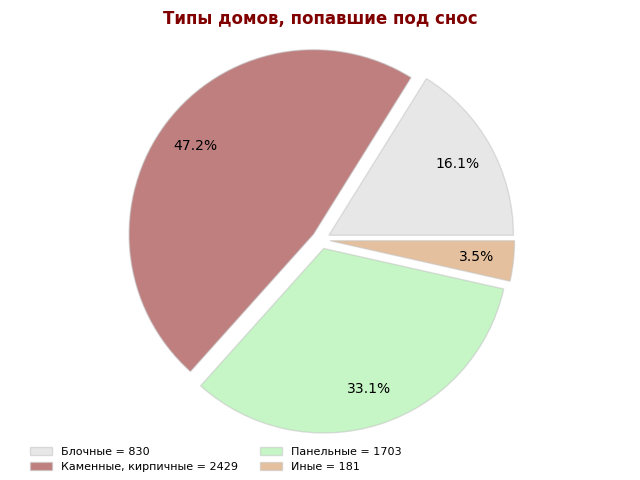

In [80]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.gridspec as gsp

dStruct=dtfResult.groupby('wall_type', as_index=False)['wall_type'].size()


dStruct['Иные']=dStruct[['Иные', 'Деревянные', 'Монолитные', 'Смешанные']].sum()
dct_plot=dStruct[['Блочные', 'Каменные, кирпичные', 'Панельные', 'Иные']].to_dict()

fig1, ax1 = plt.subplots()

fig1.suptitle('Типы домов, попавшие под снос', fontsize=12, color='maroon', fontweight='bold')

    
patches, texts, autotexts=ax1.pie(list(dct_plot.values()), autopct='%1.1f%%', radius=1,
                                        wedgeprops={'alpha':0.5, 'linewidth': 1, 
                                                    'edgecolor':'silver'}, explode=(0.05,)*len(dct_plot),
                                        shadow=False, labels=None, colors=('lightgray', 'maroon', 'lightgreen', 'peru'), 
                                  pctdistance=0.8,
                                        textprops={'weight': 'normal'}, center=[2, 2])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1.legend(patches, [('{0} = {1:.0f}').format(k, v) for k, v in dct_plot.items() ], 
                 loc=3, fontsize=8, ncol=2, bbox_to_anchor=(-0.02, -0.08), frameon=False)

plt.tight_layout(pad=2, w_pad=1, h_pad=1)

plt.show();

<IPython.core.display.Javascript object>


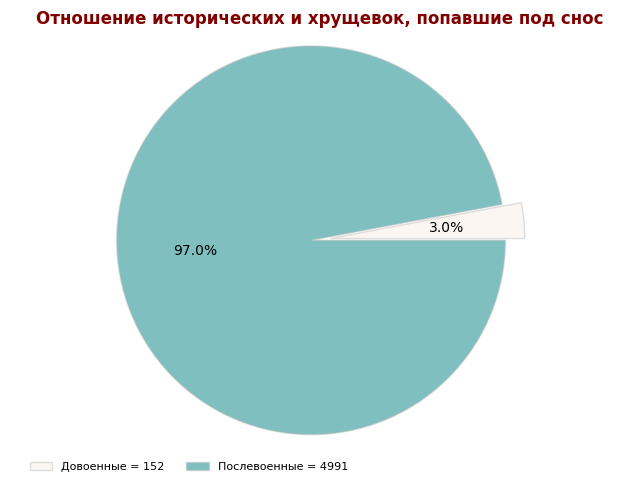

In [83]:
dHist=dtfResult

def for_map(x):
    if x < 1940: 
        return 'Довоенные' 
    else: 
        return 'Послевоенные'
    
dHist['hist']=dtfResult['year'].apply(for_map)

dHist=dtfResult.groupby('hist', as_index=False)['hist'].size()
dct_h=dHist.to_dict()

fig2, ax2 = plt.subplots()

fig2.suptitle('Отношение исторических и хрущевок, попавшие под снос', fontsize=12, color='maroon', fontweight='bold')

    
patches, texts, autotexts=ax2.pie(list(dct_h.values()), autopct='%1.1f%%', radius=1,
                                        wedgeprops={'alpha':0.5, 'linewidth': 1, 
                                                    'edgecolor':'silver'}, explode=(0.05,)*len(dct_h),
                                        shadow=False, labels=None, colors=('linen', 'teal'), 
                                        textprops={'weight': 'normal'}, center=[2, 2])
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax2.legend(patches, [('{0} = {1:.0f}').format(k, v) for k, v in dct_h.items() ], 
                 loc=3, fontsize=8, ncol=2, bbox_to_anchor=(-0.02, -0.08), frameon=False)

plt.tight_layout(pad=2, w_pad=1, h_pad=1)

plt.show();

<IPython.core.display.Javascript object>


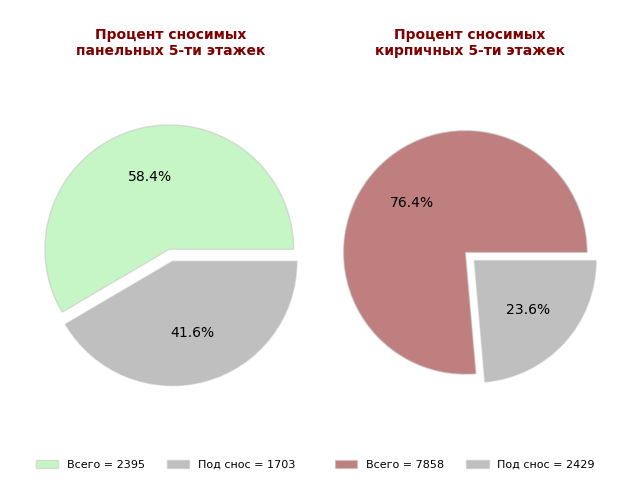

In [82]:
dtf_all_pan=dtfHouses.ix[(dtfHouses['wall_type']=='Панельные') & (dtfHouses['floors']<=5)]
dtf_all_brick=dtfHouses.ix[(dtfHouses['wall_type']=='Каменные, кирпичные') & (dtfHouses['floors']<=5)]

dct_pan={'Всего':dtf_all_pan.shape[0], 
        'Под снос':dtfResult[dtfResult['wall_type']=='Панельные'].shape[0]}

dct_brick={'Всего':dtf_all_brick.shape[0], 
        'Под снос':dtfResult[dtfResult['wall_type']=='Каменные, кирпичные'].shape[0]}
#print(dct_pan)
#print(dct_brick)


f3, (ax3, ax4) = plt.subplots(1, 2)
ax3.set_title('Процент сносимых\nпанельных 5-ти этажек', fontsize=10, color='maroon', fontweight='bold')
ax4.set_title('Процент сносимых\nкирпичных 5-ти этажек', fontsize=10, color='maroon', fontweight='bold')


p3, t3, at3=ax3.pie(list(dct_pan.values()), autopct='%1.1f%%', radius=1,
                                        wedgeprops={'alpha':0.5, 'linewidth': 1, 
                                                    'edgecolor':'silver'}, explode=(0.05,)*len(dct_pan),
                                        shadow=False, labels=None, colors=('lightgreen', 'gray'), 
                                        textprops={'weight': 'normal'}, center=[2, 2])
ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax3.legend(p3, [('{0} = {1:.0f}').format(k, v) for k, v in dct_pan.items() ], 
                 loc=3, fontsize=8, ncol=2, bbox_to_anchor=(-0.02, -0.08), frameon=False)

p4, t4, at4=ax4.pie(list(dct_brick.values()), autopct='%1.1f%%', radius=1,
                                        wedgeprops={'alpha':0.5, 'linewidth': 1, 
                                                    'edgecolor':'silver'}, explode=(0.05,)*len(dct_brick),
                                        shadow=False, labels=None, colors=('maroon', 'gray'), 
                                                                          textprops={'weight': 'normal'}, center=[2, 2])
ax4.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax4.legend(p4, [('{0} = {1:.0f}').format(k, v) for k, v in dct_brick.items() ], 
                 loc=3, fontsize=8, ncol=2, bbox_to_anchor=(-0.02, -0.08), frameon=False)

plt.tight_layout(pad=2, w_pad=1, h_pad=1)

plt.show();